<a id='final_project'></a>

# CS109 Final Project


## Title: A Real-Bogus Detection Classifier for Pan-STARRS-1 Astronomical Data

Team: The Real-Bogus Classifiers

Chris Apgar <apgar@g.harvard.edu>

Matthew Holman <mholman@cfa.harvard.edu>

Freddy Vallenilla <fvallenilladorta@g.harvard.edu>

Evan Zimmerman <zimmerman@college.harvard.edu>


#Table of Contents
* [CS109 Final Project](#final_project)
	* [Data Wrangling](#data_wrangling)



<a id='data_wrangling'></a>
## Data Wrangling and Exploratory Data Analysis

This notebook will focus on the process of collecting the data, putting it into a form that is convenient for our work as a team, and exploring the trends that might inform a more detailed analysis.


In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 200)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

C:\Users\apgarc\AppData\Local\Continuum\Anaconda\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
import sys, math, commands, os
from math import degrees
import ephem
from astropy.io import fits
from scipy import spatial
#import healpy as hp
import warnings

Here are some additional python modules that need to be loaded.  These should be accessible with the anaconda python distribution, but we'll find out for sure.

I needed to type

> pip install ephem

> pip install healpy

at the command line.  

Something failed with the healpy installation; need to sort that out.  
Tried

> pip install healpy==1.8.6

> pip install healpy==1.6.3

Same problems.

The healpy routines are only needed for managing the catalogs of known sources.  What I can do to circumvent the problem is to run a version of this on the odyssey cluster (where healpy works fine).  All we need to know is whether a given detection in the smf file coincides on the sky with a source in the catalogs.  I'll try to add a column to the tables in the smf files that as a 1 if the detection coincides with known source, and 0 if not.  Once we have that column, we no longer need the healpy routines.

Ok, I sorted this out.  It turns out I had an old xcode developer package in /Developer on my mac.  That was interfering with the healpy installation.  Regardless, we probably won't need this package.


In [3]:
# Here are various utility routines.

def sunradec(jd):
    day = jd -2415020
    sun = ephem.Sun(day)
    return degrees(sun.a_ra), degrees(sun.a_dec)

# =============================
# JD Convertor (use pyephem)
# This piece came from one of Ed's codes.
# =============================
def date2JD(Cinput):
    #2010-07-22T10:17:00.187239
    Cinput=str(Cinput)
    Cdate = Cinput.split('T')[0]
    Ctime = Cinput.split('T')[1]
    Cyear = Cdate.split('-')[0]
    Cmonth= Cdate.split('-')[1]
    Cday  = Cdate.split('-')[2]
    d = ephem.Date('%s/%s/%s %s' %(Cyear,Cmonth,Cday,Ctime))
    #print '%s/%s/%s %s' %(Cyear,Cmonth,Cday,Ctime)
    #print float(d)+2415020
    return float(d)+2415020


def get_deteff(hdu, zpt_obs, exptime):
    #print hdu.columns
    #print hdu.data
    mag_ref = hdu.header["DETEFF.MAGREF"]
    count_max = hdu.header["DETEFF.NUM"]
    mag_limit = mag_ref + zpt_obs + 2.5*math.log10(exptime)
    results = []
    for offset, count, diff_mean, diff_stdev, err_mean in hdu.data:
        results.append((offset, count, diff_mean, diff_stdev, err_mean))
    return (mag_limit, count_max, results)

def det_eff_func(x, a, b, c):
    return a*0.5*(1.0-np.tanh((x-b)/c))

# This is not used.
def adjustnan(x):
    if(np.isnan(x) or np.isinf(x)):
        return 99.0
    else:
        return x

def pick_mag(x, y):
    if(not(np.isnan(x)) and not(np.isinf(x))):
        return x
    else:
        return y

def xfold(x, xgap=8, ygap=10):
    nx = x%(600+xgap)
    return nx

def yfold(y, xgap=8, ygap=10):
    ny = y%(600+ygap)
    return ny

def mag_err2snr(mag_err):
    nsr = 1.0 - math.pow(10.0, -0.4*math.fabs(mag_err))
    if(nsr != 0.0):
        snr = 1.0/nsr
    else:
        small_err = 0.0001
        nsr = 1.0 - math.pow(10.0, -0.4*small_err)
        snr = 1.0/nsr
    return snr

def inBox(x, y, xgap=8, ygap=10, xmin=10, xmax=580, ymin=5, ymax=585):
    x_fold = xfold(x, xgap=xgap, ygap=ygap)
    y_fold = yfold(y, xgap=xgap, ygap=ygap)
    # This is what it was initially.
    #inbox = (10 < x_fold < 582 and 5 < y_fold < 589)
    # Then I tried this.
    #inbox = (10 < x_fold < 580 and 5 < y_fold < 585)
    # If I use extremely agressive masking like this, 
    # then I can get rid of the remaining striping.
    # That implies to me that some of the chips have defect 
    # regions that are much farther from the edges.
    #inbox = (200 < x_fold < 400 and 200 < y_fold < 400)
    # It seems that the x cut is more critical than the y cut.
    inbox = (xmin < x_fold < xmax and ymin < y_fold < ymax)
    return inbox

def magOK(mag, mag_err):
    mag_bad = np.isnan(mag) or np.isinf(mag) or np.isnan(mag_err) or np.isinf(mag_err)
    return not(mag_bad)

def flagOK(flag):
    return (0x1003bc88 & int(flag)) == 0

def poorFlag(flag):
    return (0xe0440130 & int(flag)) != 0


In [4]:
# Based on clever trick on
# http://stackoverflow.com/questions/9630563/bitmask-parsing-in-python-using-only-standard-library
#
def parse_flags(flag, size=32):
    return [bool(flag & (1 << size - i - 1)) for i in xrange(size)]
            
#parse_flags(0xF0F0F0F0)

FLAGS_dict = {
    'DEFAULT' :  0x00000000, # Initial value: resets all bits
    'PSFMODEL':  0x00000001, # Source fitted with a psf model (linear or non-linear)
    'EXTMODEL':  0x00000002, # Source fitted with an extended-source model
    'FITTED'  :  0x00000004, # Source fitted with non-linear model (PSF or EXT; good or bad)
    'FITFAIL' :  0x00000008, # Fit (non-linear) failed (non-converge, off-edge, run to zero)
    'POORFIT' :  0x00000010, # Fit succeeds, but low-SN, high-Chisq, or large (for PSF -- drop?)
    'PAIR'    :  0x00000020, # Source fitted with a double psf
    'PSFSTAR' :  0x00000040, # Source used to define PSF model
    'SATSTAR' :  0x00000080, # Source model peak is above saturation
    'BLEND'   :  0x00000100, # Source is a blend with other sourcers
    'EXTERNALPOS':  0x00000200, # Source based on supplied input position
    'BADPSF'   :  0x00000400, # Failed to get good estimate of object's PSF
    'DEFECT'   :  0x00000800, # Source is thought to be a defect
    'SATURATED':  0x00001000, # Source is thought to be saturated pixels (bleed trail)
    'CR_LIMIT' :  0x00002000, # Source has crNsigma above limit
    'EXT_LIMIT':  0x00004000, # Source has extNsigma above limit
    'MOMENTS_FAILURE':  0x00008000, # could not measure the moments
    'SKY_FAILURE'    :  0x00010000, # could not measure the local sky
    'SKYVAR_FAILURE' :  0x00020000, # could not measure the local sky variance
    'MOMENTS_SN'     :  0x00040000, # moments not measured due to low S/N
    'UNDEFINED'      :  0x00080000, # this bit is not defined
    'BIG_RADIUS'     :  0x00100000, # poor moments for small radius, try large radius
    'AP_MAGS'        :  0x00200000, # source has an aperture magnitude
    'BLEND_FIT'      :  0x00400000, # source was fitted as a blend
    'EXTENDED_FIT'   :  0x00800000, # full extended fit was used
    'EXTENDED_STATS' :  0x01000000, # extended aperture stats calculated
    'LINEAR_FIT'     :  0x02000000, # source fitted with the linear fit
    'NONLINEAR_FIT'  :  0x04000000, # source fitted with the non-linear fit
    'RADIAL_FLUX'    :  0x08000000, # radial flux measurements calculated
    'SIZE_SKIPPED'   :  0x10000000, # Warning:: if set, size could be determined
    'ON_SPIKE'       :  0x20000000, # peak lands on diffraction spike
    'ON_GHOST'       :  0x40000000, #peak lands on ghost or glint
    'OFF_CHIP'       :  0x80000000 #peak lands off edge of chip
    }

badlist  = ['FITFAIL', 'SATSTAR', 'BADPSF', 'DEFECT', 'SATURATED', 'CR_LIMIT', 'MOMENTS_FAILURE', 'SKY_FAILURE', 'SKYVAR_FAILURE', 'SIZE_SKIPPED']
poorlist = ['POORFIT', 'PAIR', 'BLEND', 'MOMENTS_SN', 'BLEND_FIT', 'ON_SPIKE', 'ON_GHOST', 'OFF_CHIP']

badflags = 0
for k in badlist:
    badflags += FLAGS_dict[k]
print "bad: %x" %  (badflags)

poorflags = 0
for k in poorlist:
    poorflags += FLAGS_dict[k]
print "poor: %x" % (poorflags)

FLAGS2_dict = {
    'DIFF_WITH_SINGLE': 0x00000001, # diff source matched to a single positive detection
    'DIFF_WITH_DOUBLE': 0x00000002, # diff source matched to positive detections in both images
    'MATCHED'         : 0x00000004, # source was supplied at this location from somewhere else (eg, another image, forced photometry location, etc)
    'ON_SPIKE'        : 0x00000008, # > 25% of (PSF-weighted) pixels land on diffraction spike
    'ON_STARCORE'     : 0x00000010, # > 25% of (PSF-weighted) pixels land on star core
    'ON_BURNTOOL'     : 0x00000020, # > 25% of (PSF-weighted) pixels land on burntool subtraction region
    'ON_CONVPOOR'     : 0x00000040, # > 25% of (PSF-weighted) pixels land on region where convolution had substantial masked fraction contribution
    'PASS1_SRC'       : 0x00000080, # source was detected in the first pass of psphot (bright detection stage)
    'HAS_BRIGHTER_NEIGHBOR': 0x00000100, # peak is not the brightest in its footprint
    'BRIGHT_NEIGHBOR_1'    : 0x00000200, # flux_n / (r2 flux_p) > 1
    'BRIGHT_NEIGHBOR_10'   : 0x00000400, # flux_n / (r2 flux_p) > 10
    'DIFF_SELF_MATCH'      : 0x00000800, # positive detection match is probably this source
    'SATSTAR_PROFILE'      : 0x00001000 # saturated source is modeled with a radial profile
}


bad: 1003bc88
poor: e0440130


The bit values of FLAGS and FLAGS2 are defined here:

http://svn.pan-starrs.ifa.hawaii.edu/trac/ipp/wiki/CMF_PS1_V3

The routine below processes a FITS file.  The end goal is to put the data into a pandas dataframe that can be used by the rest of the team for classification experiments.

The information that we have so far is:

0) The features that are common to all of the detections in the smf file.
1) The features that come with each detection.
2) Whether a detection coincides with a known stationary source.

Among the features that come with each detection are FLAGS and FLAGS2.  These are bitmasks that encode information from the Image Processing Pipeline.  Some of these are designated as 'poor'; they indicate that something is less than ideal about the fit, but the fit did not fail.  Others are designated as 'bad'; they indicate a failure.

```
Here is the information about the flags from Magnier et al. (2013):

FAIL             0x00000008 # Bad Fit (nonlinear) failed (non-converge, off-edge, run to zero)
POOR             0x00000010 # Poor Fit succeeds, but low-SN or high-Chisq
PAIR             0x00000020 # Poor Source fitted with a double psf
SATSTAR          0x00000080 # Bad Source model peak is above saturation
BLEND            0x00000100 # Poor Source is a blend with other sources
BADPSF           0x00000400 # Bad Failed to get good estimate of object’s PSF
DEFECT           0x00000800 # Bad Source is thought to be a defect
SATURATED        0x00001000 # Bad Source is thought to be saturated pixels (bleed trail)
CR_LIMIT         0x00002000 # Bad Source has crNsigma above limit
EXT_LIMIT        0x00004000 # Source has extNsigma above limit (Not bad)
MOMENTS_FAILURE  0x00008000 # Bad Could not measure the moments
SKY_FAILURE      0x00010000 # Bad Could not measure the local sky
SKYVAR_FAILURE   0x00020000 # Bad Could not measure the local sky variance
BELOW_MOMENTS_SN 0x00040000 # Poor Moments not measured due to low S/N
BLEND_FIT        0x00400000 # Poor Source was fitted as a blend
SIZE_SKIPPED     0x10000000 # Bad Size could not be determined
ON_SPIKE         0x20000000 # Poor Peak lands on diffraction spike
ON_GHOST         0x40000000 # Poor Peak lands on ghost or glint
OFF_CHIP         0x80000000 # Poor Peak lands off edge of chip

The sum of the bits that correspond to a 'bad' flag is:
                 0x1003bc88
                 
The sum of the bits that correspond to a 'poor' flag is:               
                 e0440130
                 
A very typical flag looks like:
                 0x02204001
 
```
                 
This means a linear fit was completed, with aperture magnitudes, extNsigma above the limit, with a psf model.  (nSigma deviations from psf to ext)

More information is available at:               
http://svn.pan-starrs.ifa.hawaii.edu/trac/ipp/wiki/CMF_PS1_V3

These things indicate that a detection is suspicious:

    * One of the "bad flag" bits is set

    * SNR < 5

    * PSF_QF_PERFECT < 0.4 or 0.5

    * detection is near the edge of a cell

There are a bunch of other features that might be relevant:

    * psf_npix

    * PSF_QF


In [5]:
# This routine opens a FITS file named infile and processes it.

def process_file(infile, outfile, headerfile, txtfile):
    tfile = open(txtfile, "w")
    with fits.open(infile) as hdulist:

        warnings.resetwarnings()
        warnings.filterwarnings('ignore', category=UserWarning, append=True)

        # Collect some primary header information
        zpt_obs  = hdulist[0].header["ZPT_OBS"]
        filterID = hdulist[0].header["FILTERID"].rstrip('.00000')
        ra_c     = hdulist[0].header["RA"]
        dec_c    = hdulist[0].header["DEC"]
        exptime  = hdulist[0].header["EXPTIME"]
        mjdObs   = hdulist[0].header["MJD-OBS"]
        airmass  = hdulist[0].header["AIRMASS"]
    
        # Do a few calculations
        jd = mjdObs + 2400000.5
        sun_ra = sunradec(jd)[0]
        sun_dec = sunradec(jd)[1]

        snr_thresh = 5.0
        qfp_thresh = 0.4
        search_radius = 1.6*math.pi/180.
        '''
        tree = get_catalog_tree(ra_c, dec_c, search_radius)
        if tree == None:
            return None
        '''

        print filterID

        reject = 0
        bad = 0
        on_edge = 0
        low_snr = 0
        on_star_count = 0
        qfp_count = 0
        j = 0
        nrows_total = 0
        newhdus = []
        shutoutc = None
        ra_all = np.empty([])
        dec_all = np.empty([])
        x_all = np.empty([])
        y_all = np.empty([])
        
        det_eff_dict = {}
        chip_dict = {}
        
        for hdu in hdulist:
            #print hdu.name
            ext_type = hdu.name.split('.')[-1]
            if ext_type == 'deteff':
                #print hdu.header
                chip=hdu.header['EXTHEAD'].rstrip('.hdr')
                # One of the detection efficiency extensions.
                # We'll want to do something with this information.
                det_eff_tup = get_deteff(hdu, zpt_obs, exptime)
                det_eff_dict[chip] = det_eff_tup
                #offs = np.array(map(lambda v: v[0], det_eff_tup[2]), dtype=np.float64)
                #popt, pv = sp.optimize.curve_fit(det_eff_func, offs, fracs, p0=[0.5, 0.0, 0.3], sigma=mean_errs)

            elif ext_type == 'hdr':
                # One of the psf postage stamp extensions
                # We can get shutoutc from here, but we
                # only need to do that once.
                if shutoutc == None:
                    try:
                        shutoutc = hdu.header['SHUTOUTC']
                        shutcutc = hdu.header['SHUTCUTC']
                    except Exception,e:
                        pass
            
            elif ext_type == 'psf' and "EXTTYPE" in hdu.header and (hdu.header["EXTTYPE"] == "PS1_V3"):
            # One of the extensions with tables of detections.
            # This holds our primary data.
                chip=hdu.header['EXTHEAD'].rstrip('.hdr')
                hdu_name = hdu.name.split('.')[0]
                nrows = hdu.header['NAXIS2']
                nrows_total = nrows_total + nrows

                col_dict = {}
                series_dict = {}
                #print hdu.columns.names
                for col in hdu.columns.names:
                    col_dict[col] = hdu.data.field(col)
                    series_dict[col] = pd.Series(hdu.data.field(col).byteswap().newbyteorder())
                
                hdu_df = pd.DataFrame.from_dict(series_dict)
                chip_dict[chip] = hdu_df
                
                ras  = col_dict['RA_PSF']
                decs = col_dict['DEC_PSF']
                xs   = col_dict['X_PSF']
                ys   = col_dict['Y_PSF']
                x_sigs   = col_dict['X_PSF_SIG']
                y_sigs   = col_dict['Y_PSF_SIG']
                plts = col_dict['PLTSCALE']
                mag0s= col_dict['CAL_PSF_MAG']
                mag1s= col_dict['PSF_INST_MAG'] + zpt_obs + 2.5*math.log10(exptime)
                mags = map(pick_mag, mag0s, mag1s)
                mag_errs = col_dict['PSF_INST_MAG_SIG']
                psf_minors= col_dict['PSF_MINOR']*plts
                psf_majors= col_dict['PSF_MAJOR']*plts
                flags    = col_dict['FLAGS']
                flags2   = col_dict['FLAGS2']
                fwhms = 2.3548 * np.sqrt(psf_majors*psf_minors)
                moments_R1s = col_dict['MOMENTS_R1']*plts
                psf_qf_perfects = col_dict['PSF_QF_PERFECT']
                psf_extents = (moments_R1s*moments_R1s)/(psf_majors*psf_minors)
                on_stars = col_dict['on_star']
                
                snrs = map(mag_err2snr, mag_errs)
                
                # There really are just a few calculations in the lines above.
                # All can easily be done on the resulting dataframes instead.
                #
                # mag1s convert from instrumental magnitude
                # mags to chose the best magnitude between mag0 and mag1
                # psf_minor, psf_major, and moments_R1 converted to arcseconds
                # psf_extent calculated (but this needs to be fixed)
                # SNR calculation

                #qpoints = convert_points(ras, decs)
                #idx_fr = tree.query_ball_point(qpoints, sr)
                #offStar_mask = [matches == [] for matches in idx_fr]

                inBox_mask = [inBox(x, y) for x, y in zip(xs, ys)]
                magOK_mask = [magOK(mag, mag_err) for mag, mag_err in zip(mags, mag_errs)]
                qfp_mask   = [qfp >= qfp_thresh for qfp in psf_qf_perfects]
                offStar_mask = [on_star == 0 for on_star in on_stars]
                goodFlag_mask = [flagOK(flag) for flag in flags]
                snr_mask   = [snr >= snr_thresh for snr in snrs]

                mask = map(lambda u, v, w, x, y, z: (u and v and w and x and y and  z), inBox_mask, magOK_mask, offStar_mask, qfp_mask, goodFlag_mask, snr_mask)
                #mask = map(lambda x, y: (x and y), inBox_mask, magOK_mask)
                mask = np.array(mask)
                
                ra_all= np.append(ra_all, ras[mask])
                dec_all= np.append(dec_all, decs[mask])
                x_all= np.append(x_all, xs[mask])
                y_all= np.append(y_all, ys[mask])

                # Here we can check which detections are angularly close to known sources
                # by comparing to a catalog with a KD-tree.
                # 

                hdu.data = hdu.data[mask]

                for i, (ra, dec, x, y, x_sig, y_sig, mag, mag_err, fwhm, flag, flag2, psf_major, psf_minor, moments_R1, psf_qf_perfect, psf_extent, on_star) in enumerate(zip(ras, decs, xs, ys, x_sigs, y_sigs, mags, mag_errs, fwhms, flags, flags2, psf_majors, psf_minors, moments_R1s, psf_qf_perfects, psf_extents, on_stars)):
                    #if inBox_mask[i] and magOK_mask[i] and offStar_mask[i]:
                    #if inBox_mask[i] and magOK_mask[i]:
                    if True:
                        snr = mag_err2snr(mag_err)
                        #pix = ra_dec2pix(ra, dec, nside, nested=nested_scheme)
                        #pix = -1
                        #print flag
                        if (0x1003bc88 & int(flag)) != 0:
                            bad += 1
                            #print "|%32s" % ("{0:b}".format(int(flag)))
                            #print "|%32s" % ("{0:b}".format(0x1003bc88))
                            #print "|%32s" % ("{0:b}".format(0x1003bc88 & int(flag)))
                            #print parse_flags(int(flag))
                        if on_star==1:
                            on_star_count += 1
                        if psf_qf_perfect < qfp_thresh:
                            qfp_count +=1
                        if not(inBox_mask[i]):
                            on_edge +=1
                        if snr < snr_thresh:
                            low_snr +=1
                        if (0x1003bc88 & int(flag)) != 0 or snr < snr_thresh or not(inBox_mask[i]) or on_star or not(magOK_mask[i]) or psf_qf_perfect < qfp_thresh:
                            reject +=1
                        else:
                            wstring = "%d %lf %lf %lf %lf %x %s %.3lf %.3lf %.3lf %.3lf %.3lf %.3lf %.3lf %.3lf %.3lf %.3lf %.3lf %x %d %x %d %d\n" % \
                                (j, ra, dec, mag, mag_err, flag, chip, fwhm, snr, x, y, x_sig, y_sig, psf_major, psf_minor, moments_R1, psf_qf_perfect, psf_extent, flag2, on_star, (0x1003bc88 & int(flag)), psf_qf_perfect<0.5, inBox_mask[i])
                            tfile.write(wstring)

                    j = j+1

            elif hdu.name == 'PRIMARY':
                # One of the first extension.
                # There is nothing to do, at this point.
                pass
            
            elif hdu.name == 'MATCHED_REFS':
                # One of the first extension.
                # There is nothing to do, at this point.
                print hdu.columns.names
                col_dict = {}
                series_dict = {}
                #print hdu.columns.names
                for col in hdu.columns.names:
                    col_dict[col] = hdu.data.field(col)
                    series_dict[col] = pd.Series(hdu.data.field(col).byteswap().newbyteorder())
                matched_refs_df = pd.DataFrame.from_dict(series_dict)
                pass

            else:
                # Unknown type of extension.
                #print "Some other kind of extension " + hdu.name
                pass

            newhdus.append(hdu)

        thdulist = fits.HDUList(newhdus)
        thdulist.writeto(outfile, clobber=True, output_verify="silentfix")
        #print shutoutc
        shutoutc_jd = date2JD(shutoutc)
        output_txt = '%20.10f %6.3f %s %11.6f %12.6f %6.3f %8.4f %s %11.6f %12.6f' % (shutoutc_jd, exptime, str(filterID), ra_c, dec_c, airmass, zpt_obs, shutoutc, sun_ra, sun_dec)
        h = open(headerfile, 'w')
        h.write(output_txt+'\n')
        h.close()
        tfile.close()
        print "total rows: ", j
        print "reject:     ", reject
        print "bad:        ", bad
        print "on_star:    ", on_star_count
        print "low SNR:    ", low_snr
        print "on edge:    ", on_edge
        print "qfp bad:    ", qfp_count
        print "remaining:  ", j - reject
        return ra_all, dec_all, x_all, y_all, mask, chip_dict, det_eff_dict, matched_refs_df


In [6]:
def smf2pandas(infile, snr_thresh=5.0, qfp_thresh=0.4, FLAGS_dict=None, FLAGS2_dict=None):

    with fits.open(infile) as hdulist:

        warnings.resetwarnings()
        warnings.filterwarnings('ignore', category=UserWarning, append=True)

        # Collect some primary header information
        zpt_obs  = hdulist[0].header["ZPT_OBS"]
        filterID = hdulist[0].header["FILTERID"].rstrip('.00000')
        exptime  = hdulist[0].header["EXPTIME"]
        mjdObs   = hdulist[0].header["MJD-OBS"]
        airmass  = hdulist[0].header["AIRMASS"]
    
        # Do a few calculations
        jd = mjdObs + 2400000.5

        #print filterID

        shutoutc = None
        
        chip_dict = {}
        
        for hdu in hdulist:
            #print hdu.name
            ext_type = hdu.name.split('.')[-1]
            if ext_type == 'deteff':
                #print hdu.header
                # One of the detection efficiency extensions.
                # We'll want to do something with this information.
                #det_eff_tup = get_deteff(hdu, zpt_obs, exptime)
                #popt, pv = sp.optimize.curve_fit(det_eff_func, offs, fracs, p0=[0.5, 0.0, 0.3], sigma=mean_errs)
                pass
            
            elif ext_type == 'hdr':
                # One of the psf postage stamp extensions
                # We can get shutoutc from here, but we
                # only need to do that once.
                if shutoutc == None:
                    try:
                        shutoutc = hdu.header['SHUTOUTC']
                        shutcutc = hdu.header['SHUTCUTC']
                    except Exception,e:
                        pass
            
            elif ext_type == 'psf' and "EXTTYPE" in hdu.header and (hdu.header["EXTTYPE"] == "PS1_V3"):
            # One of the extensions with tables of detections.
            # This holds our primary data.
                chip=hdu.header['EXTHEAD'].rstrip('.hdr')
                hdu_name = hdu.name.split('.')[0]

                col_dict = {}
                series_dict = {}
                #print hdu.columns.names
                for col in hdu.columns.names:
                    col_dict[col] = hdu.data.field(col)
                    series_dict[col] = pd.Series(hdu.data.field(col).byteswap().newbyteorder())
                
                chip_dict[chip] = pd.DataFrame.from_dict(series_dict)
                
                plts = col_dict['PLTSCALE']
                mag0s= col_dict['CAL_PSF_MAG']
                mag1s= col_dict['PSF_INST_MAG'] + zpt_obs + 2.5*math.log10(exptime)
                mags = map(pick_mag, mag0s, mag1s)
                mag_errs = col_dict['PSF_INST_MAG_SIG']
                psf_minors= col_dict['PSF_MINOR']
                psf_majors= col_dict['PSF_MAJOR']
                fwhms = 2.3548 * np.sqrt(psf_majors*psf_minors) * plts
                moments_xxs = col_dict['MOMENTS_XX']
                moments_yys = col_dict['MOMENTS_YY']
                psf_extents = np.sqrt((moments_xxs*moments_yys)/(psf_majors*psf_minors))
                snrs = map(mag_err2snr, mag_errs)
                
                sLength = len(chip_dict[chip].index)
                chip_dict[chip]['chip'] = pd.Series([chip]*sLength, index=chip_dict[chip].index)
                chip_dict[chip]['filterID'] = pd.Series([filterID]*sLength, index=chip_dict[chip].index)                
                chip_dict[chip]['mag'] = pd.Series(mags, index=chip_dict[chip].index)
                chip_dict[chip]['snr'] = pd.Series(snrs, index=chip_dict[chip].index)
                chip_dict[chip]['fwhm'] = pd.Series(fwhms, index=chip_dict[chip].index)
                chip_dict[chip]['psf_extent'] = pd.Series(psf_extents, index=chip_dict[chip].index)

            elif hdu.name == 'PRIMARY' or hdu.name == 'MATCHED_REFS':
                # One of the first two extensions.
                # There is nothing to do, at this point.
                pass

            else:
                # Unknown type of extension.
                    #print "Some other kind of extension " + hdu.name
                pass


        shutoutc_jd = date2JD(shutoutc)
        #output_txt = '%20.10f %6.3f %s %11.6f %12.6f %6.3f %8.4f %s %11.6f %12.6f' % (shutoutc_jd, exptime, str(filterID), ra_c, dec_c, airmass, zpt_obs, shutoutc, sun_ra, sun_dec)

        newdf = pd.concat([chip_dict[chip] for chip in chip_dict], ignore_index = True)
        
        # Break out the flag bits into individual indicator columns
        if(FLAGS_dict != None):
            for k, v in FLAGS_dict.iteritems():
                mask = newdf['FLAGS'].astype(int) & v != 0
                newdf[k] = pd.Series(mask, index=newdf.index)
                
        if(FLAGS2_dict != None):
            for k, v in FLAGS2_dict.iteritems():
                mask = newdf['FLAGS2'].astype(int) & v != 0
                newdf[k] = pd.Series(mask, index=newdf.index)

        return chip_dict, newdf


### Get an example "smf" file.

The Pan-STARRS-1 data that we will be using is in the form of "smf" files.  The smf files are in the FITS format.

In [7]:
infile = 'test.star.smf' # This is an example file.
outfile = 'test.star.n.smf'
txtfile = 'test.star.n.txt'
headerfile = 'test.star.n.pointing'
ra_all, dec_all, x_all, y_all, mask, chip_dict, det_eff_dict, matched_refs_df = process_file(infile, outfile, headerfile, txtfile)

z
['RA', 'DEC', 'X_CHIP', 'Y_CHIP', 'X_CHIP_FIT', 'Y_CHIP_FIT', 'X_FPA', 'Y_FPA', 'MAG_INST', 'MAG_REF', 'COLOR_REF', 'CHIP_ID']
total rows:  77824
reject:      70165
bad:         2599
on_star:     51766
low SNR:     11417
on edge:     16339
qfp bad:     2609
remaining:   7659


(7660L,)

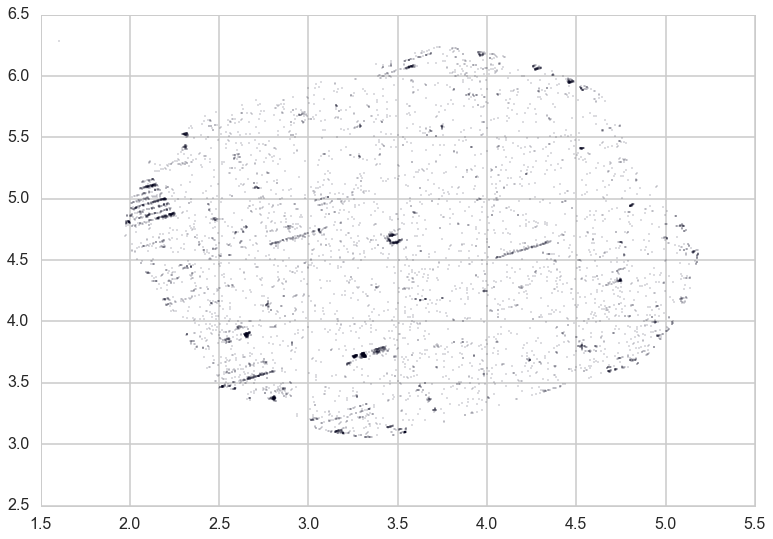

In [8]:
plt.scatter(ra_all, dec_all, s=0.1)
plt.xlim(1.5,5.5)
plt.ylim(2.5,6.5)
ra_all.shape

In [9]:
def make_colorful_plot(chip_dict):
    colors = cm.rainbow(np.linspace(0.1, 1, len(chip_dict)))
    for chip, c in zip(chip_dict, colors):
        plt.scatter(chip_dict[chip].RA_PSF, chip_dict[chip].DEC_PSF, s=0.1, label=chip, color=c)
        ram = chip_dict[chip].RA_PSF.mean()
        decm =chip_dict[chip].DEC_PSF.mean()
        plt.annotate(chip, xy=(ram,decm), xytext=(ram+0.1,decm-0.05), fontsize=15)
    # Note: I am inverting the x axis because that is the way it looks on the sky.
    # That is, right ascension (astro-speak for a longitude on the sky) increases to the left.
    plt.gca().invert_xaxis()
    plt.xlabel('RA (deg)')
    plt.ylabel('Dec (deg)')
    plt.title('Pan-STARRS-1 Gigapixel Camera')

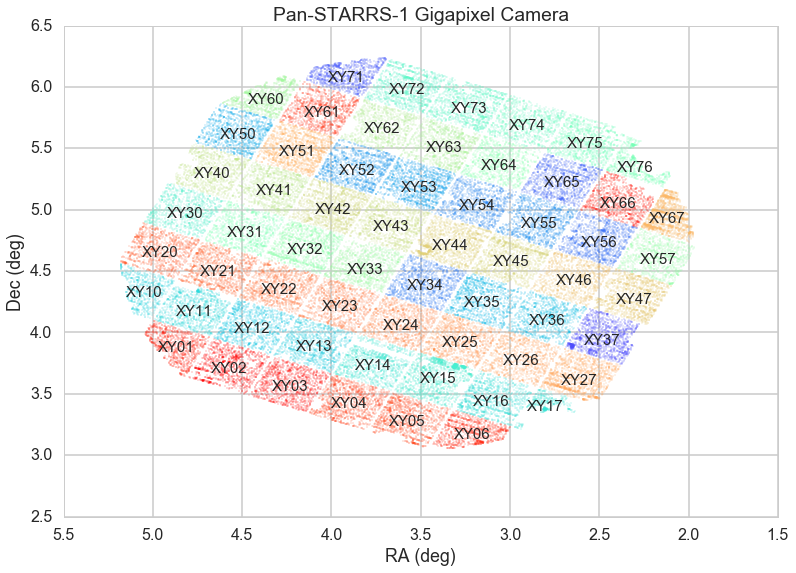

In [10]:
chip_dict, newdf = smf2pandas(infile, FLAGS_dict=FLAGS_dict, FLAGS2_dict=FLAGS2_dict)
make_colorful_plot(chip_dict)

(7660L,)

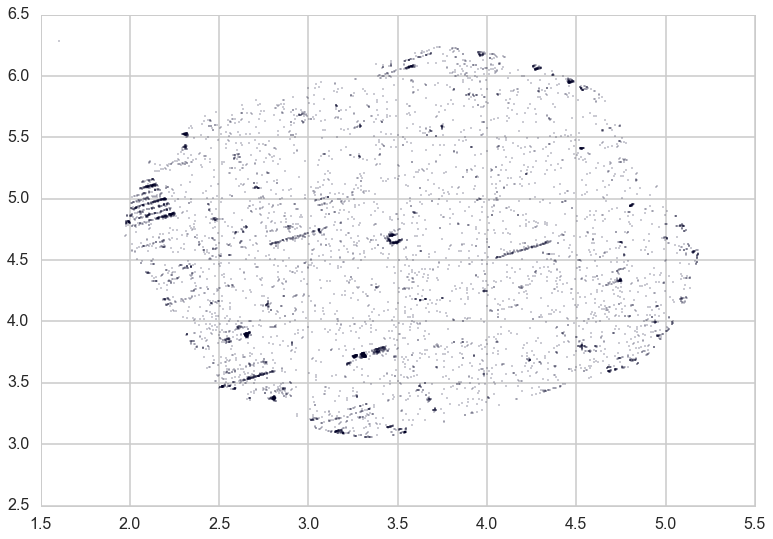

In [11]:
plt.scatter(ra_all, dec_all, s=0.2)
plt.xlim(1.5,5.5)
plt.ylim(2.5,6.5)
ra_all.shape

In [12]:
newdf[newdf.mp_desig != 'None'].shape

(172, 106)

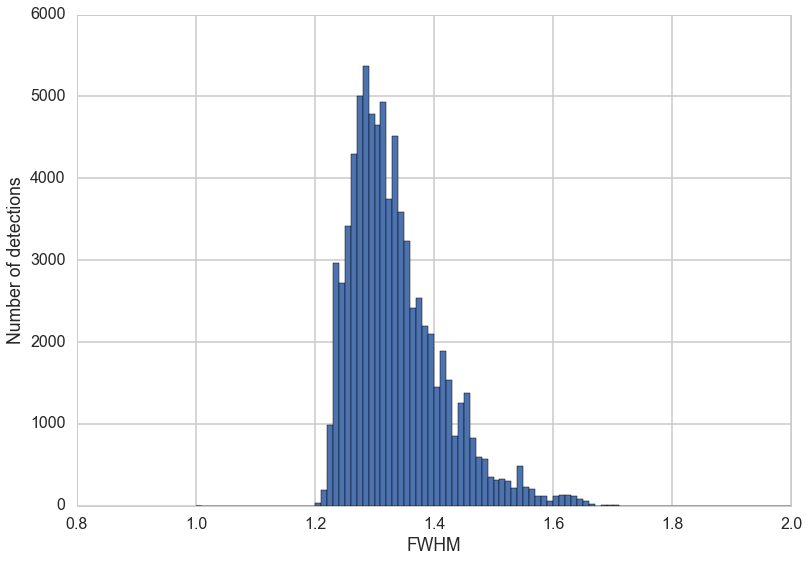

In [13]:

n, nbins, patches = plt.hist(newdf['fwhm'], bins=100, range=[1,2])
plt.xlabel("FWHM")
plt.ylabel("Number of detections")


0.997328579426


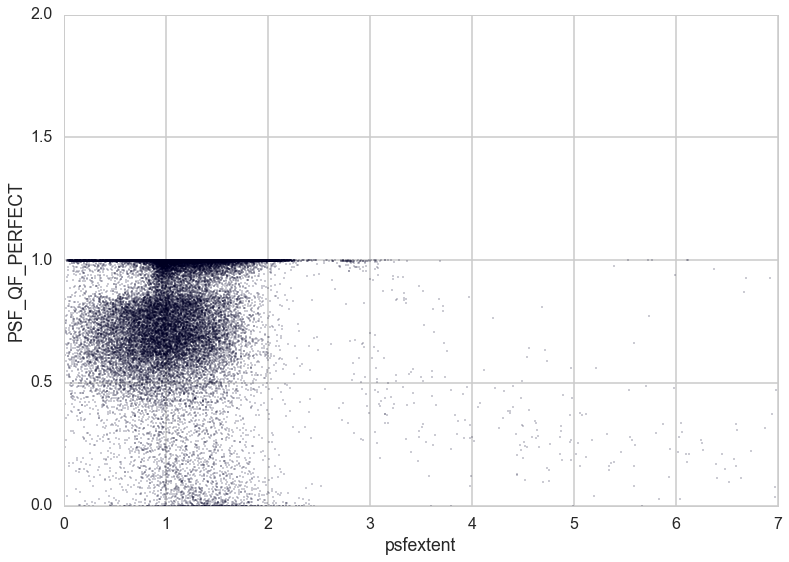

In [14]:
psfquality = newdf['PSF_QF_PERFECT']
print psfquality.median()
plt.scatter(newdf['psf_extent'], psfquality, s=0.2)
plt.xlim(0,7)
plt.ylim(0,2)
plt.xlabel("psfextent")
plt.ylabel("PSF_QF_PERFECT")

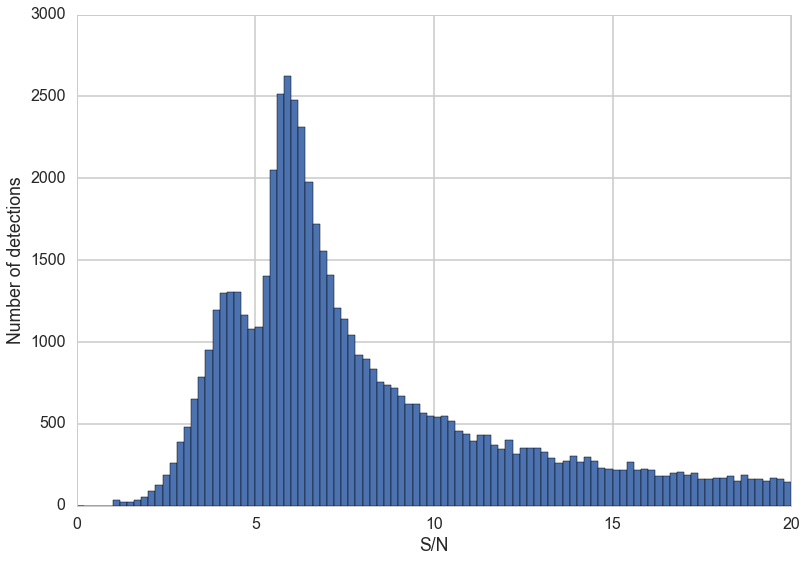

In [15]:
n, nbins, patches = plt.hist(newdf['snr'], bins=100, range=[0,20])
plt.xlabel("S/N")
plt.ylabel("Number of detections")


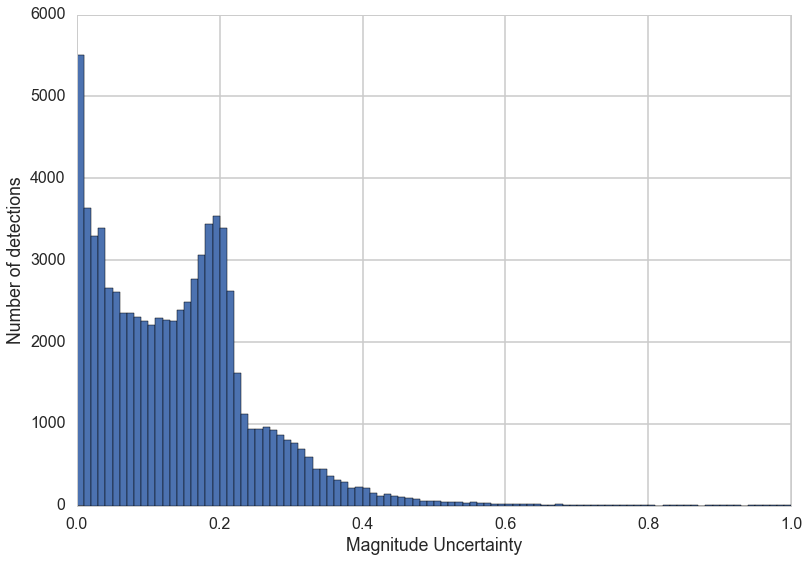

In [16]:

n, nbins, patches = plt.hist(newdf['PSF_INST_MAG_SIG'], bins=100, range=[0,1])
plt.xlabel("Magnitude Uncertainty")
plt.ylabel("Number of detections")


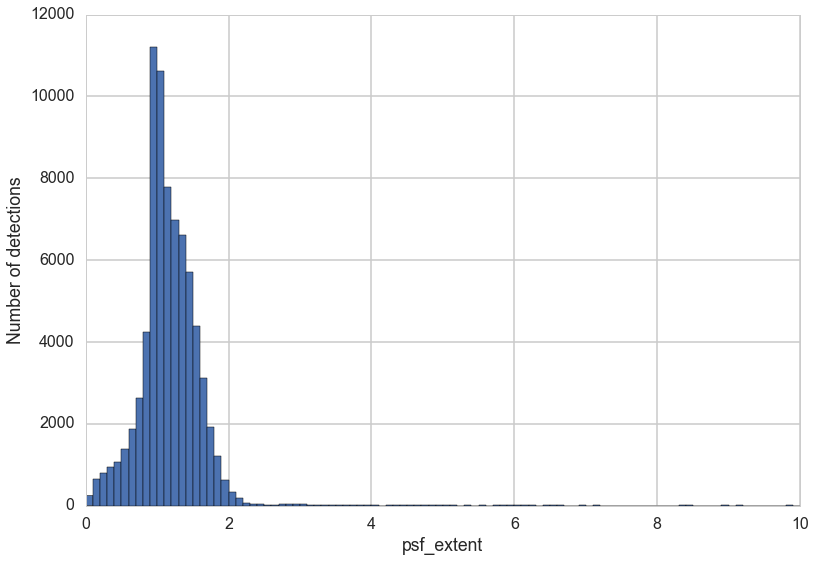

In [17]:

n, nbins, patches = plt.hist(newdf['psf_extent'], bins=100, range=[0,10])
plt.xlabel("psf_extent")
plt.ylabel("Number of detections")


The detectors in the Pan-STARRS-1 Gigapixel camera (GPC1) are prototypes, with many defects.  Each detector is a 4800x4800 Orthogonal Tranfer Array (OTA), composed of 64 cells, in an 8x8 grid.  Each 600 pixel x 600 pixel cell can be read out independently.

We see that many detections are associated with the edges of these cells.  That is evident in the two histograms below, of the x and y positions of the detections, respectively.

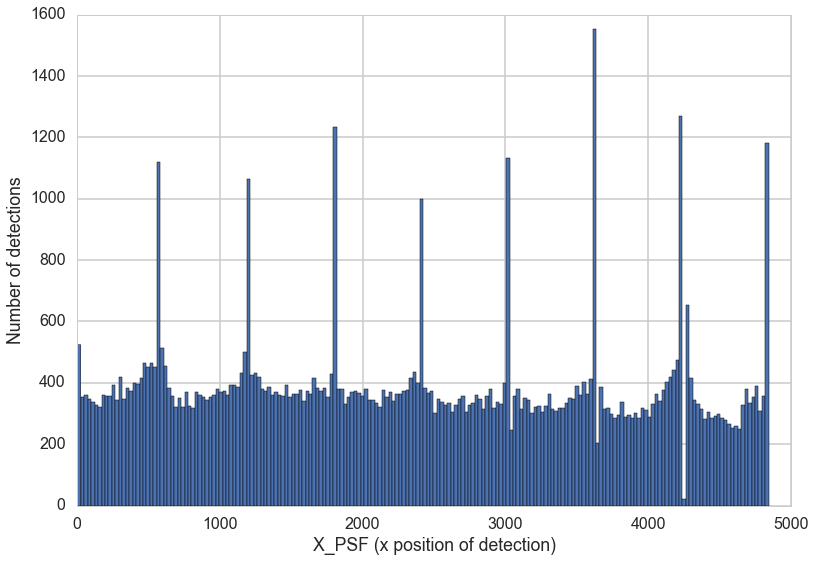

In [18]:
n, nbins, patches = plt.hist(newdf['X_PSF'], bins=200)
plt.xlabel("X_PSF (x position of detection)")
plt.ylabel("Number of detections")

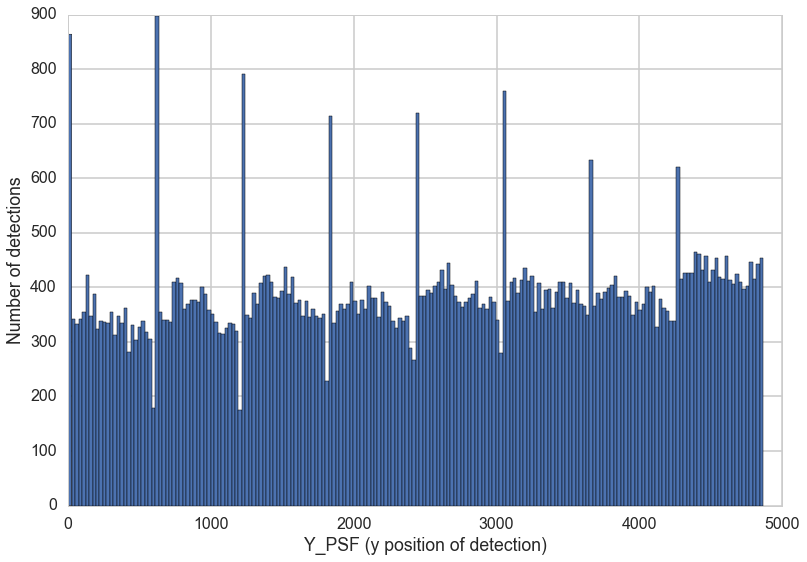

In [19]:
n, nbins, patches = plt.hist(newdf['Y_PSF'], bins=200)
plt.xlabel("Y_PSF (y position of detection)")
plt.ylabel("Number of detections")

Now I would like to add some more columns to the dataframe.  These are indicators of various characteristics of the detections.

In [20]:
snr_thresh = 5.0 # This should probably be set in a cell at the top of the notebook.
qpf_thresh = 0.4 # Same here.

flag_mask = newdf['FLAGS'].apply(flagOK)
snr_mask =  newdf['snr'].apply(lambda x: x >= snr_thresh)
inBox_mask = np.array(map(lambda (x, y): inBox(x, y), zip(newdf['X_PSF'], newdf['Y_PSF'])))
magOK_mask = np.array(map(lambda (x, y): magOK(x, y), zip(newdf['mag'], newdf['PSF_INST_MAG_SIG'])))
qfp_mask   = newdf['PSF_QF_PERFECT'].apply(lambda x: x >= qpf_thresh)
offStar_mask =  newdf['on_star']==0

# good_mask refers to detections that pass all the various checks
good_mask = flag_mask & snr_mask & inBox_mask & magOK_mask & qfp_mask

# remainder_mask refers to detections that pass all the tests and which are not on a star.
remainder_mask = good_mask & offStar_mask

newdf['flagsOK'] = pd.Series(flag_mask, index=newdf.index)
newdf['in_box']  = pd.Series(inBox_mask, index=newdf.index)
newdf['magOK']   = pd.Series(magOK_mask, index=newdf.index)
newdf['qfpOK']   = pd.Series(qfp_mask, index=newdf.index)


In [21]:
newdf['FLAGS'].apply(poorFlag).sum()

828

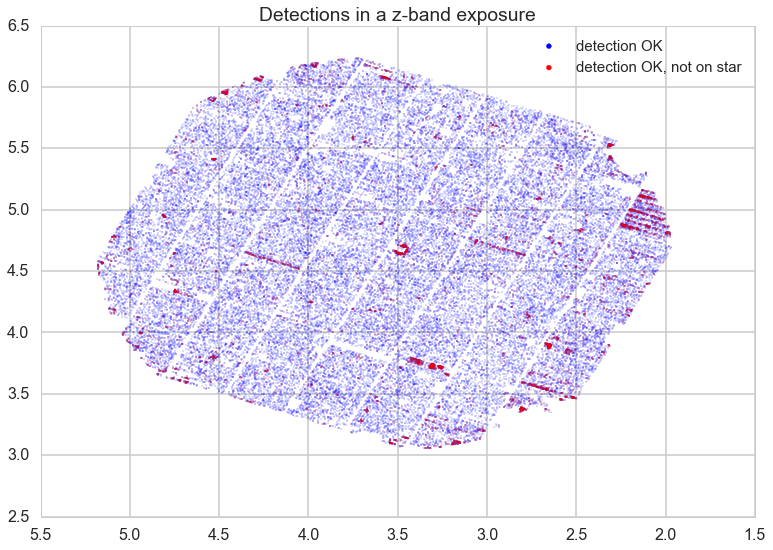

In [22]:
s1 = plt.scatter(newdf[good_mask].RA_PSF, newdf[good_mask].DEC_PSF, s=0.1, color='blue', label='detection OK')
s2 = plt.scatter(newdf[remainder_mask].RA_PSF, newdf[remainder_mask].DEC_PSF, s=0.1, color='red', label='detection OK, not on star')
plt.title('Detections in a z-band exposure')
leg = plt.legend(markerscale=15, fontsize=15)
plt.gca().invert_xaxis()

What I see in the plot above, aside from the expected roughly uniform distribution of astrophysical sources, are some linear groups of detections and some clumps of detections.  

The linear groups are probably the same kind of detections along the edges of cells that we've seen before.  Perhaps there is a bug in the inBox_mask or perhaps the region that should be removed varies from detector to detector.

The clumps of detections are either real, extended groups of stars such as globular clusters, or they are clumps of false detections around a saturated bright star or around a large detector defect.

It is hard to determine visually how many of the false positives are in these linear or clumped features, but it could be a significant fraction of the total (half).


In [23]:
newdf[newdf.chip=='XY76'].shape

(766, 110)

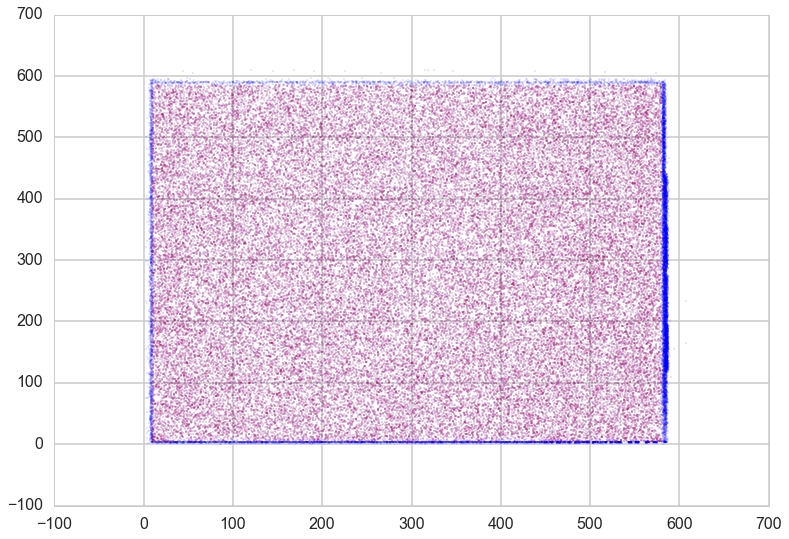

In [24]:
plt.scatter(xfold(newdf['X_PSF']), yfold(newdf['Y_PSF']), s=0.05, color='blue')
plt.scatter(xfold(newdf['X_PSF'][inBox_mask]), yfold(newdf['Y_PSF'][inBox_mask]), s=0.05, color='red')

# It can be that there are lines of false detections in individual detections that do not show
# up in this plot because they are obscured by the other detections.


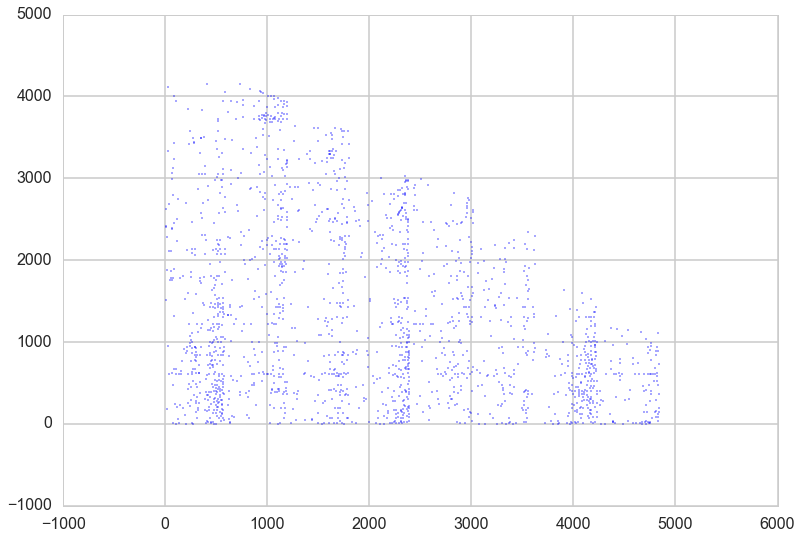

In [25]:
# Need to make this plot from many examples from the same chip, essentially to map out the
# the defect mask for each chip, not just those features that are common to all chips.
# Here's an example for a particularly bad detector, without folding
plt.scatter(chip_dict['XY67']['X_PSF'], chip_dict['XY67']['Y_PSF'], s=0.5, color='blue')


The "badFlags" mask that I used above is supposed to eliminate 20-25% of the false detections, according to Metcalfe et al. (2013) [MNRAS 435, 1825–1839 (2013)] and Magnier et al. (2013) [].

If I take 2148 as 20% of the false detections the fraction of the total is 10740.

So, what are some things that remain to be done?

1. We can tune the SNR threshhold.
2. We can tune the PSF_QF_PERFECT threshhold.
3. We can tune the detector edge cuts.
4. We can use stacks of smf files to map out false positive regions of each detector.
5. We can look at the 'poor' masks to see if any of those fields are important.
6. I need to identify the known moving objects in the field.
7. I could use a bright star catalog (with proper motions incorporated) to locate the bright stars in the exposure in order to mask out bigger regions.

In [26]:
2148/0.2

10740.0

In [27]:
det_eff_tup = det_eff_dict['XY02']
count_max = det_eff_tup[1]
offs = np.array(map(lambda v: v[0], det_eff_tup[2]), dtype=np.float64)
fluxes = np.power(10.0,-0.4*offs)
counts = np.array(map(lambda v: float(v[1]), det_eff_tup[2]), dtype=np.float64)
mean_errs = np.array(map(lambda v: v[4], det_eff_tup[2]), dtype=np.float64)
fracs = counts/count_max


[ 0.78124728  0.06668515  0.33321289]


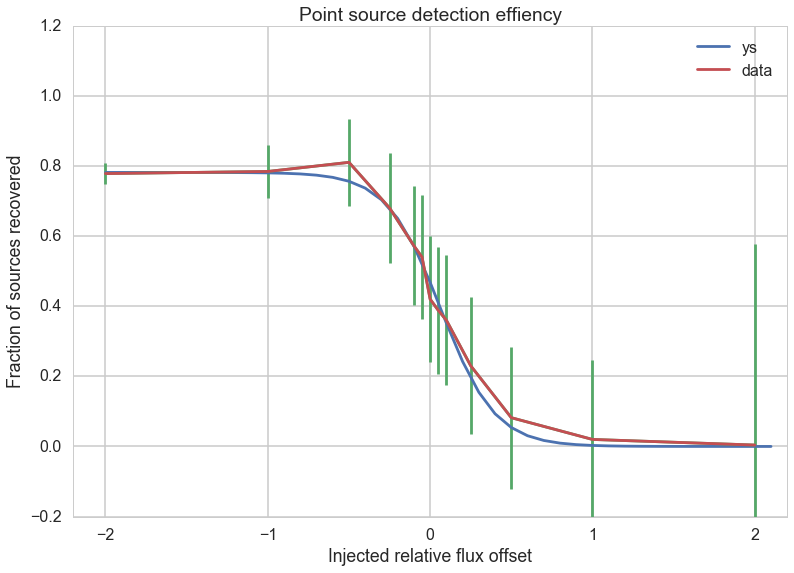

In [28]:
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a*0.5*(1.0-np.tanh((x-b)/c))

def func2(x, a, b, c):
    return a*0.5*(1.0-sp.special.erf((x-b)/c))

popt, pv = curve_fit(func, offs, fracs, p0=[0.3, 0.05, 0.3], sigma=mean_errs)
print popt

#popt2, pv = curve_fit(func2, offs, fracs, p0=[0.3, 0.05, 0.3], sigma=mean_errs)
#print popt2
xs = np.arange(-2,2.2,0.1)
ys = func(xs, popt[0], popt[1], popt[2])
#ys2 = func(xs, popt2[0], popt2[1], popt2[2])

plt.plot(xs,ys, label='ys')
#plt.plot(xs,ys2, label='ys2')
plt.errorbar(offs, fracs, yerr=mean_errs)
plt.plot(offs, fracs, label='data')
plt.ylim(-0.2,1.2)
plt.xlim(-2.2, 2.2)
plt.xlabel("Injected relative flux offset")
plt.ylabel("Fraction of sources recovered")
plt.title("Point source detection effiency")
plt.legend()

In [29]:
(2148/0.2)/77825

0.1380019274012207

The question is how many of the remainig 80% of the false detections we can remove.

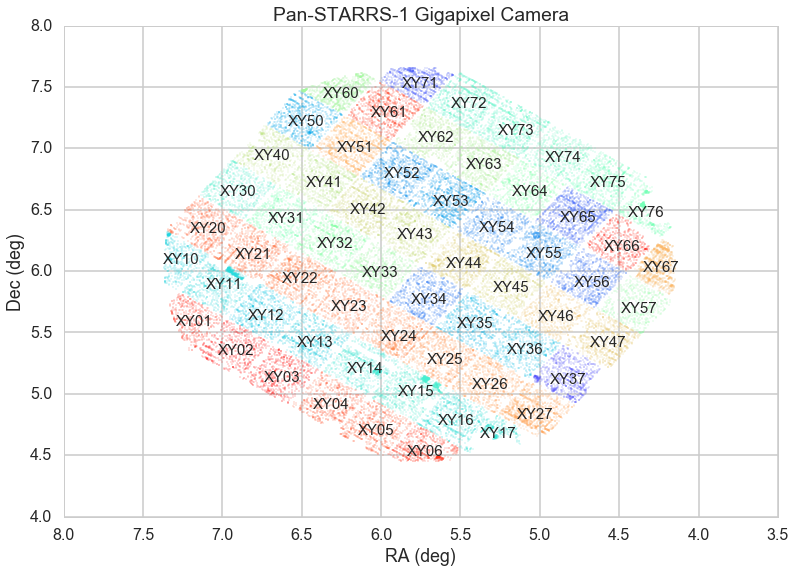

In [30]:
chip_dict, newdf = smf2pandas('data/o5895g0004o.424868.cm.333484.n.smf')
#newdf = pd.concat([chip_dict[chip] for chip in chip_dict], ignore_index = True)
make_colorful_plot(chip_dict)

In [31]:
snr_thresh = 5.0 # This should probably be set in a cell at the top of the notebook.
qpf_thresh = 0.4 # Same here.

flag_mask = newdf['FLAGS'].apply(flagOK)
snr_mask =  newdf['snr'].apply(lambda x: x >= snr_thresh)
inBox_mask = np.array(map(lambda (x, y): inBox(x, y), zip(newdf['X_PSF'], newdf['Y_PSF'])))
magOK_mask = np.array(map(lambda (x, y): magOK(x, y), zip(newdf['mag'], newdf['PSF_INST_MAG_SIG'])))
qfp_mask   = newdf['PSF_QF_PERFECT'].apply(lambda x: x >= qpf_thresh)
offStar_mask =  newdf['on_star']==0

# good_mask refers to detections that pass all the various checks
good_mask = flag_mask & snr_mask & inBox_mask & magOK_mask & qfp_mask

# remainder_mask refers to detections that pass all the tests and which are not on a star.
remainder_mask = good_mask & offStar_mask

newdf['flagsOK'] = pd.Series(flag_mask, index=newdf.index)
newdf['in_box']  = pd.Series(inBox_mask, index=newdf.index)
newdf['magOK']   = pd.Series(magOK_mask, index=newdf.index)
newdf['qfpOK']   = pd.Series(qfp_mask, index=newdf.index)


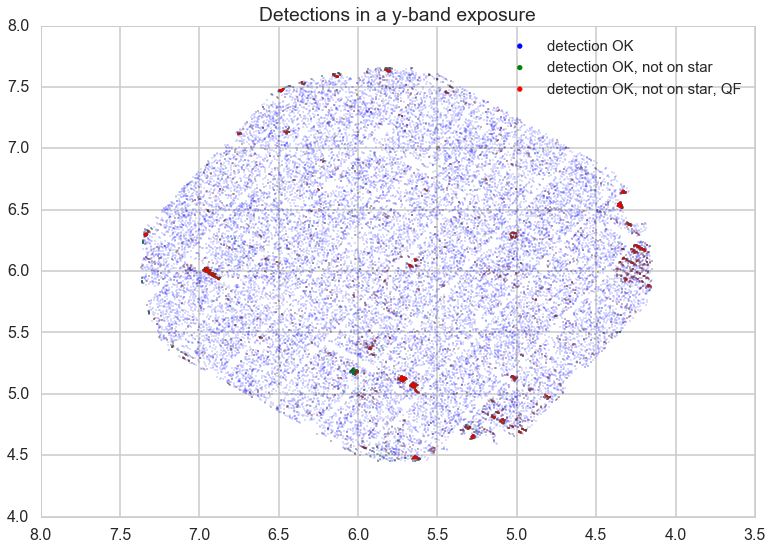

In [32]:
s1 = plt.scatter(newdf[good_mask].RA_PSF, newdf[good_mask].DEC_PSF, s=0.1, color='blue', label='detection OK')
s2 = plt.scatter(newdf[remainder_mask].RA_PSF, newdf[remainder_mask].DEC_PSF, s=0.1, color='green', label='detection OK, not on star')
s3 = plt.scatter(newdf[remainder_mask & (newdf.PSF_QF_PERFECT>=0.99)].RA_PSF, newdf[remainder_mask & (newdf.PSF_QF_PERFECT>=0.99)].DEC_PSF, s=0.1, color='red', label='detection OK, not on star, QF')

plt.title('Detections in a y-band exposure')
leg = plt.legend(markerscale=15, fontsize=15)
plt.gca().invert_xaxis()

In [33]:
print (remainder_mask & (newdf.PSF_QF_PERFECT>=0.99)).sum()
print (remainder_mask).sum()


3899
4805


In [34]:
newdf.head()

,AP_MAG,AP_MAG_RADIUS,AP_MAG_RAW,CAL_PSF_MAG,CAL_PSF_MAG_SIG,CR_NSIGMA,DEC_PSF,EXT_NSIGMA,FLAGS,FLAGS2,IPP_IDET,KRON_FLUX,KRON_FLUX_ERR,KRON_FLUX_INNER,KRON_FLUX_OUTER,MOMENTS_M3C,MOMENTS_M3S,MOMENTS_M4C,MOMENTS_M4S,MOMENTS_R1,MOMENTS_RH,MOMENTS_XX,MOMENTS_XY,MOMENTS_YY,N_FRAMES,PADDING,PADDING2,PEAK_FLUX_AS_MAG,PLTSCALE,POSANGLE,PSF_CHISQ,PSF_INST_FLUX,PSF_INST_FLUX_SIG,PSF_INST_MAG,PSF_INST_MAG_SIG,PSF_MAJOR,PSF_MINOR,PSF_NDOF,PSF_NPIX,PSF_QF,PSF_QF_PERFECT,PSF_THETA,RA_PSF,SKY,SKY_SIGMA,X_PSF,X_PSF_SIG,Y_PSF,Y_PSF_SIG,mp_dec_rate,mp_desig,mp_mag,mp_prox,mp_ra_rate,on_star,chip,filterID,mag,snr,fwhm,psf_extent,flagsOK,in_box,magOK,qfpOK
0,-16.105915,8,-15.989053,11.544366,0.015625,NaN,5.188569,23.870026,640696327,128,0,2771294.25000,2088.662354,794063.500000,183158.296875,0.193679,-1.979877,0.660624,0.040192,5.168977,1.999534,5.839915,-0.347463,11.006875,0,0,0,-11.385881,0.255615,-44.986790,821271.8125,1693271.125000,1653.803101,-15.571816,0.000977,2.270140,1.697595,2703,2704,0.998480,0.998480,0.573213,4.755702,276.657104,17.481617,1575.474365,0.002078,2030.260132,0.002078,NaN,None,NaN,NaN,NaN,1,XY37,y,11.544366,1112.147383,1.181637,4.084059,True,True,True,True
1,-14.943736,8,-14.826873,12.057705,0.015625,NaN,5.153399,4.367692,103825415,128,1,987895.87500,1202.969482,211830.859375,76612.031250,0.269641,-0.458750,0.035072,-0.042921,3.854464,1.843775,5.546052,-0.261767,5.475727,0,0,0,-11.348567,0.255725,-44.969368,69091.5625,1055336.250000,1273.284912,-15.058477,0.001207,2.101094,1.628697,2690,2691,0.958371,0.958371,45.229836,4.835621,277.131989,17.105103,2631.537598,0.002567,2647.817383,0.002567,NaN,None,NaN,NaN,NaN,1,XY37,y,12.057705,900.390413,1.113961,2.978996,True,True,True,True
2,-15.665754,8,-15.548891,12.146197,0.015625,NaN,5.247891,38.314117,103825415,160,2,2104803.50000,1825.540527,879232.437500,309640.843750,-0.308689,-6.184803,-0.249143,0.015020,5.365948,1.728602,8.452147,-0.033962,12.142209,0,0,0,-11.265514,0.255899,-44.971111,1324781.8750,972734.437500,1277.515503,-14.969985,0.001313,2.036710,1.648822,2687,2688,0.993818,0.172318,44.426552,4.895709,277.821533,17.326918,2051.020020,0.002794,4115.729980,0.002794,NaN,None,NaN,NaN,NaN,1,XY37,y,12.146197,827.208689,1.104269,5.528164,True,True,True,False
3,-14.947728,8,-14.830865,14.733263,0.015625,NaN,5.248050,92.086113,36716545,32,3,409750.28125,1009.182800,602965.250000,259217.578125,-0.365963,-5.953179,-0.996090,-0.090508,2.423606,0.776113,4.258163,0.007898,14.550693,0,0,0,-11.234550,0.255900,-44.971077,1095452.8750,89777.585938,808.500732,-12.382919,0.009006,2.036703,1.648822,2687,2688,0.924442,0.165580,45.077869,4.895940,277.823822,17.330652,2051.114746,0.019161,4119.679199,0.019161,NaN,None,NaN,NaN,NaN,0,XY37,y,14.733263,121.063073,1.104269,4.295387,True,True,True,False
4,-14.104372,8,-13.987509,NaN,0.015625,NaN,5.188786,NaN,35651585,0,4,262711.56250,1134.996582,17863.488281,320032.656250,0.343143,-0.294403,-0.227317,0.054171,2.423606,0.478637,0.343924,-0.076929,1.847633,0,0,0,-11.134068,0.255616,-44.986794,542203.1875,-48257.441406,756.796509,NaN,0.015682,2.269076,1.697253,2600,2601,0.998087,0.998087,-53.644722,4.755981,276.661987,17.480345,1575.299316,0.033367,2035.246338,0.033367,NaN,None,NaN,NaN,NaN,0,XY37,y,NaN,69.733620,1.181243,0.406201,True,True,False,True


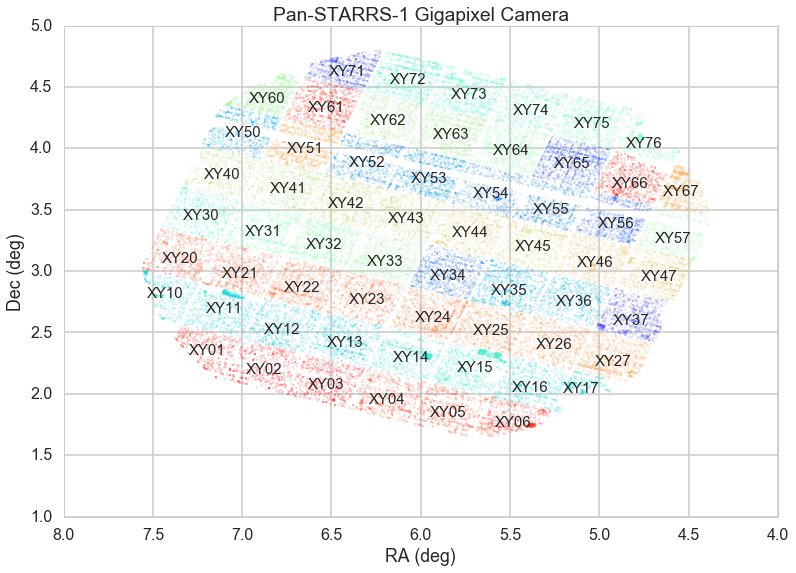

In [35]:
chip_dict, newdict = smf2pandas('data/o5895g0005o.424869.cm.333488.n.smf')
make_colorful_plot(chip_dict)

In [36]:
snr_thresh = 5.0 # This should probably be set in a cell at the top of the notebook.
qpf_thresh = 0.4 # Same here.

flag_mask = newdf['FLAGS'].apply(flagOK)
poor_mask = newdf['FLAGS'].apply(poorFlag)
snr_mask =  newdf['snr'].apply(lambda x: x >= snr_thresh)
inBox_mask = np.array(map(lambda (x, y): inBox(x, y), zip(newdf['X_PSF'], newdf['Y_PSF'])))
magOK_mask = np.array(map(lambda (x, y): magOK(x, y), zip(newdf['mag'], newdf['PSF_INST_MAG_SIG'])))
qfp_mask   = newdf['PSF_QF_PERFECT'].apply(lambda x: x >= qpf_thresh)
offStar_mask =  newdf['on_star']==0

# good_mask refers to detections that pass all the various checks
good_mask = flag_mask & snr_mask & inBox_mask & magOK_mask & qfp_mask

# remainder_mask refers to detections that pass all the tests and which are not on a star.
remainder_mask = good_mask & offStar_mask

newdf['flagsOK'] = pd.Series(flag_mask, index=newdf.index)
newdf['in_box']  = pd.Series(inBox_mask, index=newdf.index)
newdf['magOK']   = pd.Series(magOK_mask, index=newdf.index)
newdf['qfpOK']   = pd.Series(qfp_mask, index=newdf.index)


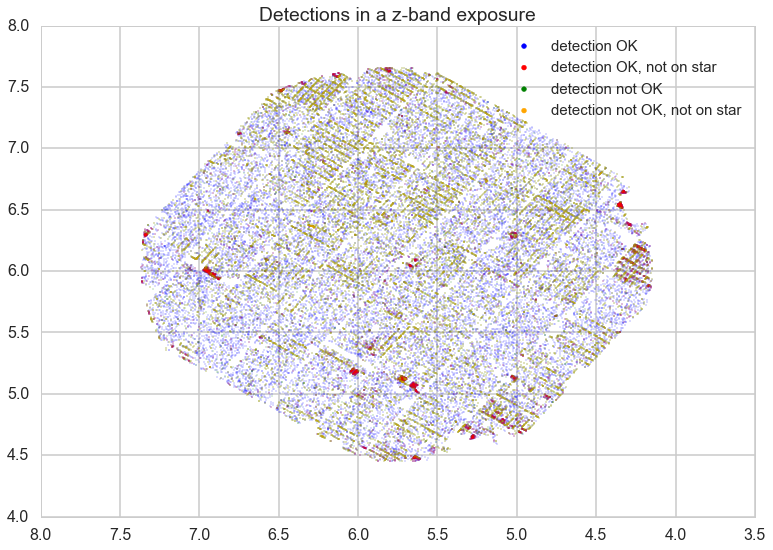

In [37]:
s1 = plt.scatter(newdf[good_mask].RA_PSF, newdf[good_mask].DEC_PSF, s=0.1, color='blue', label='detection OK')
s2 = plt.scatter(newdf[remainder_mask].RA_PSF, newdf[remainder_mask].DEC_PSF, s=0.1, color='red', label='detection OK, not on star')
s3 = plt.scatter(newdf[~good_mask].RA_PSF, newdf[~good_mask].DEC_PSF, s=0.1, color='green', label='detection not OK')
s4 = plt.scatter(newdf[~good_mask & offStar_mask].RA_PSF, newdf[~good_mask & offStar_mask].DEC_PSF, s=0.1, color='orange', label='detection not OK, not on star')

plt.title('Detections in a z-band exposure')
leg = plt.legend(markerscale=15, fontsize=15)
plt.gca().invert_xaxis()

What fraction of the detections that are "on-star" also have the flags and other characteristics of detections that we think are likely false positives?  From that number we can estimate the fraction of real moving sources that we might classify as false (aside from any additional issues with trailing).

How can we stack the files of remaining detections to better identify the per-chip regions that generate false positives?  

In [38]:
float(remainder_mask.sum())/remainder_mask.shape[0]

0.0983502538071066

In [39]:
float((~good_mask & ~offStar_mask).sum())/(~offStar_mask).sum()

0.061151614343103705

At least in this case, about 6% of the detections that coincide with stars are also flagged as likely false positives.  

We can break this down further.

In [40]:
float((~flag_mask & ~offStar_mask).sum())/(~offStar_mask).sum()

0.017073352179735157

About 1% of the "on-star" detections also have bad flags.  Some of those are bright, known stars that are saturated.  Those are not moving objects; it's ok to exclude them.

In [41]:
float((~snr_mask & ~offStar_mask).sum())/(~offStar_mask).sum()

0.011382234786490105

About 1% of the "on-star" detections are below the S/N cut.  These are likely objects that were detected at higher S/N in other, more sensitive bands.

In [42]:
float((~inBox_mask & ~offStar_mask).sum())/(~offStar_mask).sum()

0.039093884838565691

About 4% of the "on-star" detections are along the edges.  This seems low, based on the ~8% of detector area that is eliminated (30 pixels out of 600 in the x direction and 20 pixels out of 600 in the y direction).  I will double check this, but it could mean that stars are less detectable on the edges as well.  That seems plausible, if the edge regions are less sensitive.

In [43]:
float((~qfp_mask & ~offStar_mask).sum())/(~offStar_mask).sum()

0.014767147745871151

Fewer than 2% of the "on-star" detections do not satisfy the PSF_QF_PERFECT cut.

In [44]:
float((~magOK_mask & ~offStar_mask).sum())/(~offStar_mask).sum()

0.0040916530278232409

An very small fraction of the "on-star" detections have a NaN or Inf for their magnitudes or magnitude uncertainties.

What about other flags and characteristics?

In [45]:
float((poor_mask & ~offStar_mask).sum())/(~offStar_mask).sum()

0.0014134801368843922

In [46]:
float((poor_mask & offStar_mask).sum())/(offStar_mask).sum()

0.0024121609320953939

Very few of the detections, either "on-star" or off, have any of the poor mask flags set.

In [47]:
#float((~good_mask & ~offStar_mask).sum())/(~offStar_mask).sum()
float((good_mask & (newdf.mp_desig != 'None')).sum())/(newdf.mp_desig != 'None').sum()

0.95890410958904104

In [48]:
for k, v in FLAGS_dict.iteritems():
    mask = newdf['FLAGS'].astype(int) & v != 0
    newdf[k] = pd.Series(mask, index=newdf.index)

for k, v in FLAGS2_dict.iteritems():
    mask = newdf['FLAGS2'].astype(int) & v != 0
    newdf[k] = pd.Series(mask, index=newdf.index)

In [49]:
newdf[~good_mask & (newdf.mp_desig != 'None')]

,AP_MAG,AP_MAG_RADIUS,AP_MAG_RAW,CAL_PSF_MAG,CAL_PSF_MAG_SIG,CR_NSIGMA,DEC_PSF,EXT_NSIGMA,FLAGS,FLAGS2,IPP_IDET,KRON_FLUX,KRON_FLUX_ERR,KRON_FLUX_INNER,KRON_FLUX_OUTER,MOMENTS_M3C,MOMENTS_M3S,MOMENTS_M4C,MOMENTS_M4S,MOMENTS_R1,MOMENTS_RH,MOMENTS_XX,MOMENTS_XY,MOMENTS_YY,N_FRAMES,PADDING,PADDING2,PEAK_FLUX_AS_MAG,PLTSCALE,POSANGLE,PSF_CHISQ,PSF_INST_FLUX,PSF_INST_FLUX_SIG,PSF_INST_MAG,PSF_INST_MAG_SIG,PSF_MAJOR,PSF_MINOR,PSF_NDOF,PSF_NPIX,PSF_QF,PSF_QF_PERFECT,PSF_THETA,RA_PSF,SKY,SKY_SIGMA,X_PSF,X_PSF_SIG,Y_PSF,Y_PSF_SIG,mp_dec_rate,mp_desig,mp_mag,mp_prox,mp_ra_rate,on_star,chip,filterID,mag,snr,fwhm,psf_extent,flagsOK,in_box,magOK,qfpOK,BIG_RADIUS,MOMENTS_FAILURE,EXT_LIMIT,EXTERNALPOS,DEFAULT,NONLINEAR_FIT,DEFECT,SKY_FAILURE,LINEAR_FIT,RADIAL_FLUX,PSFSTAR,POORFIT,SKYVAR_FAILURE,PAIR,OFF_CHIP,BLEND,FITFAIL,MOMENTS_SN,SATURATED,BLEND_FIT,AP_MAGS,SIZE_SKIPPED,CR_LIMIT,ON_SPIKE,BADPSF,EXTENDED_FIT,UNDEFINED,EXTENDED_STATS,SATSTAR,FITTED,EXTMODEL,ON_GHOST,PSFMODEL,HAS_BRIGHTER_NEIGHBOR,ON_STARCORE,ON_CONVPOOR,PASS1_SRC,DIFF_SELF_MATCH,BRIGHT_NEIGHBOR_1,SATSTAR_PROFILE,ON_BURNTOOL,BRIGHT_NEIGHBOR_10,DIFF_WITH_DOUBLE,DIFF_WITH_SINGLE,MATCHED
8854,-6.077059,9,-5.984974,20.569780,0.015625,NaN,7.077491,-2.184605,35651585,0,398,179.231354,146.853210,-66.435150,200.424942,-2.762279,-0.118012,-0.877804,0.874754,2.570158,1.273339,0.693455,-0.199901,1.402294,0,0,0,-4.326085,0.255767,135.114914,1484.785522,415.490479,144.241272,-6.546402,0.347159,2.266585,1.870543,1308,1309,0.656503,0.656503,9.078724,6.386470,273.356964,16.859529,1451.897339,0.738636,4860.485840,0.738636,-0.113480,G0078,20.538,0.604497,0.151114,0,XY50,y,20.569780,3.654089,1.240135,0.478915,True,False,True,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
10451,-7.508618,8,-7.398751,19.476772,0.015625,NaN,5.424146,-0.990148,35653633,0,393,807.289001,170.655869,162.489944,-3.891174,0.468148,0.041055,0.072014,0.006573,2.299248,1.559269,0.991593,-0.595845,1.477076,0,0,0,-4.409597,0.256370,-44.980930,1697.119751,1137.008545,128.155182,-7.639409,0.112713,2.158670,1.612744,1630,1631,0.945965,0.945965,-84.226677,5.108486,280.031708,17.123562,1792.697144,0.239814,2842.939453,0.239814,0.012084,78457,19.481,0.117321,0.174724,0,XY36,y,19.476772,10.141435,1.126412,0.648623,False,True,True,True,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
33539,-6.653100,9,-6.561648,19.783669,0.015625,NaN,5.422342,-0.596445,35651585,0,369,684.779785,141.850037,332.469086,-4.415924,0.946865,-0.806119,0.315249,0.296243,2.511304,1.210113,2.513843,-0.074639,0.990440,0,0,0,-4.365182,0.255698,134.966965,1664.202271,857.049255,135.885315,-7.332514,0.158550,2.381335,1.711413,1523,1524,0.814379,0.814379,-27.462524,4.673165,275.390961,16.725546,1641.993286,0.337341,1834.178467,0.337341,-0.165949,42961,19.942,0.196469,0.188083,0,XY47,y,19.783669,7.360068,1.215540,0.781619,True,False,True,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False


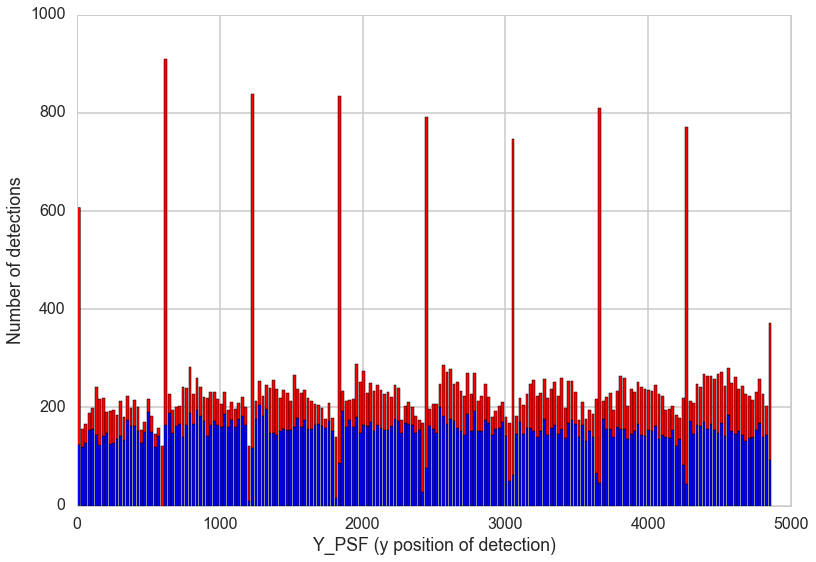

In [50]:
y0 = newdf[good_mask].Y_PSF.values
y1 = newdf[~good_mask].Y_PSF.values
colors = ['blue', 'red']
labels = ['good', 'not good']
n, nbins, patches = plt.hist([y0, y1], bins=200, color=colors, label=labels, stacked=True)

#n, nbins, patches = plt.hist(newdf[good_mask].Y_PSF, bins=200)
plt.xlabel("Y_PSF (y position of detection)")
plt.ylabel("Number of detections")

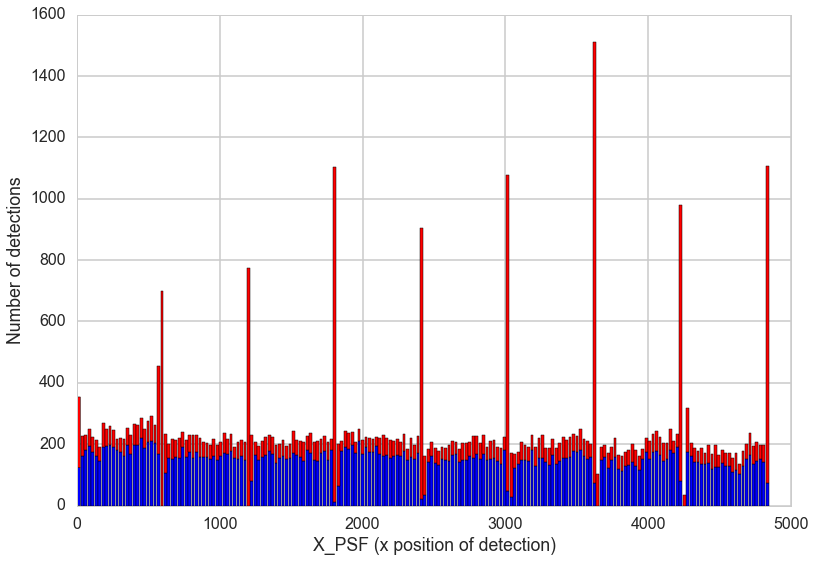

In [51]:
x0 = newdf[good_mask].X_PSF.values
x1 = newdf[~good_mask].X_PSF.values
colors = ['blue', 'red']
labels = ['good', 'not good']
n, nbins, patches = plt.hist([x0, x1], bins=200, color=colors, label=labels, stacked=True)

#n, nbins, patches = plt.hist(newdf[good_mask].Y_PSF, bins=200)
plt.xlabel("X_PSF (x position of detection)")
plt.ylabel("Number of detections")

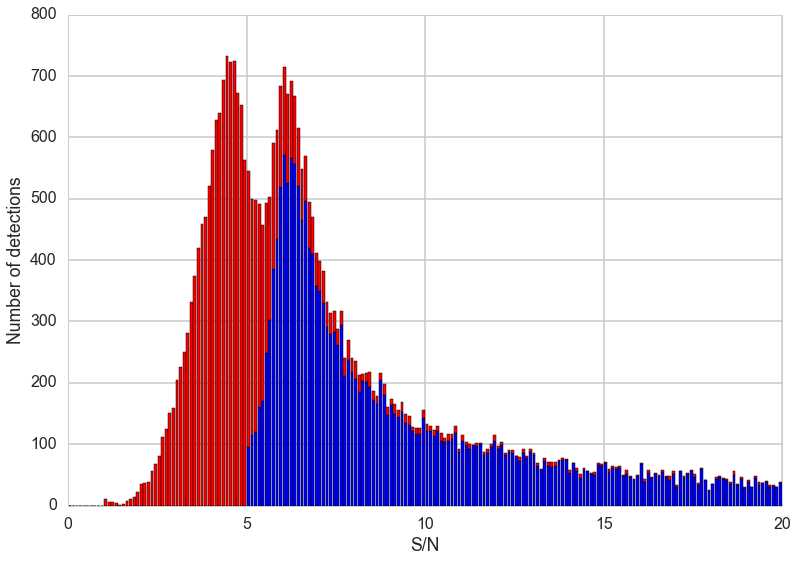

In [52]:
s0 = newdf[good_mask].snr.values
s1 = newdf[~good_mask].snr.values
colors = ['blue', 'red']
labels = ['good', 'not good']
n, nbins, patches = plt.hist([s0, s1], bins=200, color=colors, label=labels, stacked=True, range=[0,20])

#n, nbins, patches = plt.hist(newdf[good_mask].Y_PSF, bins=200)
plt.xlabel("S/N")
plt.ylabel("Number of detections")

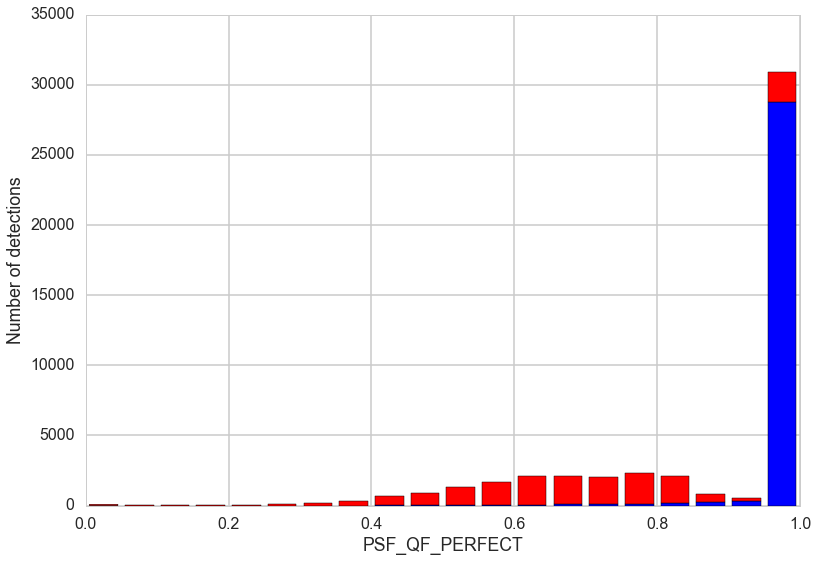

In [53]:
s0 = newdf[good_mask].PSF_QF_PERFECT.values
s1 = newdf[~good_mask].PSF_QF_PERFECT.values
colors = ['blue', 'red']
labels = ['good', 'not good']
n, nbins, patches = plt.hist([s0, s1], bins=20, color=colors, label=labels, stacked=True, range=[0,1])

#n, nbins, patches = plt.hist(newdf[good_mask].Y_PSF, bins=200)
plt.xlabel("PSF_QF_PERFECT")
plt.ylabel("Number of detections")

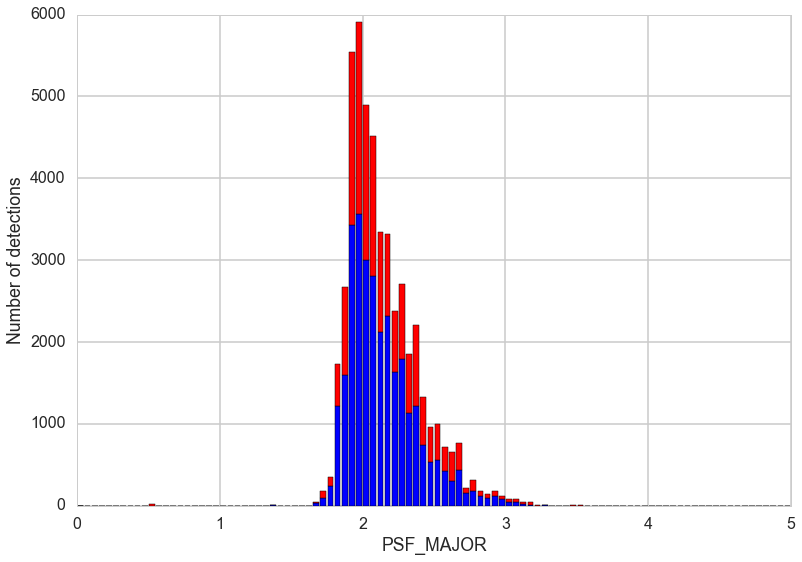

In [54]:
s0 = newdf[good_mask].PSF_MAJOR.values
s1 = newdf[~good_mask].PSF_MAJOR.values
colors = ['blue', 'red']
labels = ['good', 'not good']
n, nbins, patches = plt.hist([s0, s1], bins=100, color=colors, label=labels, stacked=True, range=[0,5])

#n, nbins, patches = plt.hist(newdf[good_mask].Y_PSF, bins=200)
plt.xlabel("PSF_MAJOR")
plt.ylabel("Number of detections")

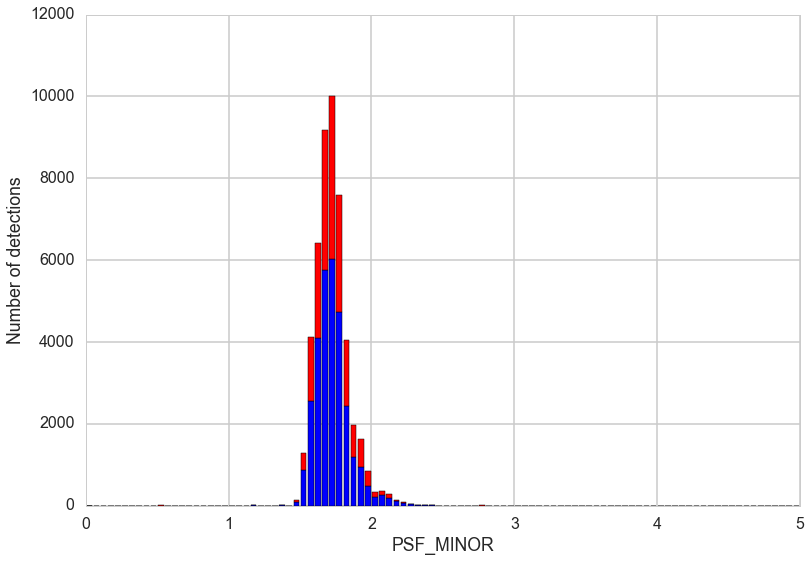

In [55]:
s0 = newdf[good_mask].PSF_MINOR.values
s1 = newdf[~good_mask].PSF_MINOR.values
colors = ['blue', 'red']
labels = ['good', 'not good']
n, nbins, patches = plt.hist([s0, s1], bins=100, color=colors, label=labels, stacked=True, range=[0,5])

#n, nbins, patches = plt.hist(newdf[good_mask].Y_PSF, bins=200)
plt.xlabel("PSF_MINOR")
plt.ylabel("Number of detections")

In [56]:
newdf[(newdf.PSF_QF != newdf.PSF_QF_PERFECT) & (newdf.mp_desig != 'None')]

,AP_MAG,AP_MAG_RADIUS,AP_MAG_RAW,CAL_PSF_MAG,CAL_PSF_MAG_SIG,CR_NSIGMA,DEC_PSF,EXT_NSIGMA,FLAGS,FLAGS2,IPP_IDET,KRON_FLUX,KRON_FLUX_ERR,KRON_FLUX_INNER,KRON_FLUX_OUTER,MOMENTS_M3C,MOMENTS_M3S,MOMENTS_M4C,MOMENTS_M4S,MOMENTS_R1,MOMENTS_RH,MOMENTS_XX,MOMENTS_XY,MOMENTS_YY,N_FRAMES,PADDING,PADDING2,PEAK_FLUX_AS_MAG,PLTSCALE,POSANGLE,PSF_CHISQ,PSF_INST_FLUX,PSF_INST_FLUX_SIG,PSF_INST_MAG,PSF_INST_MAG_SIG,PSF_MAJOR,PSF_MINOR,PSF_NDOF,PSF_NPIX,PSF_QF,PSF_QF_PERFECT,PSF_THETA,RA_PSF,SKY,SKY_SIGMA,X_PSF,X_PSF_SIG,Y_PSF,Y_PSF_SIG,mp_dec_rate,mp_desig,mp_mag,mp_prox,mp_ra_rate,on_star,chip,filterID,mag,snr,fwhm,psf_extent,flagsOK,in_box,magOK,qfpOK,BIG_RADIUS,MOMENTS_FAILURE,EXT_LIMIT,EXTERNALPOS,DEFAULT,NONLINEAR_FIT,DEFECT,SKY_FAILURE,LINEAR_FIT,RADIAL_FLUX,PSFSTAR,POORFIT,SKYVAR_FAILURE,PAIR,OFF_CHIP,BLEND,FITFAIL,MOMENTS_SN,SATURATED,BLEND_FIT,AP_MAGS,SIZE_SKIPPED,CR_LIMIT,ON_SPIKE,BADPSF,EXTENDED_FIT,UNDEFINED,EXTENDED_STATS,SATSTAR,FITTED,EXTMODEL,ON_GHOST,PSFMODEL,HAS_BRIGHTER_NEIGHBOR,ON_STARCORE,ON_CONVPOOR,PASS1_SRC,DIFF_SELF_MATCH,BRIGHT_NEIGHBOR_1,SATSTAR_PROFILE,ON_BURNTOOL,BRIGHT_NEIGHBOR_10,DIFF_WITH_DOUBLE,DIFF_WITH_SINGLE,MATCHED


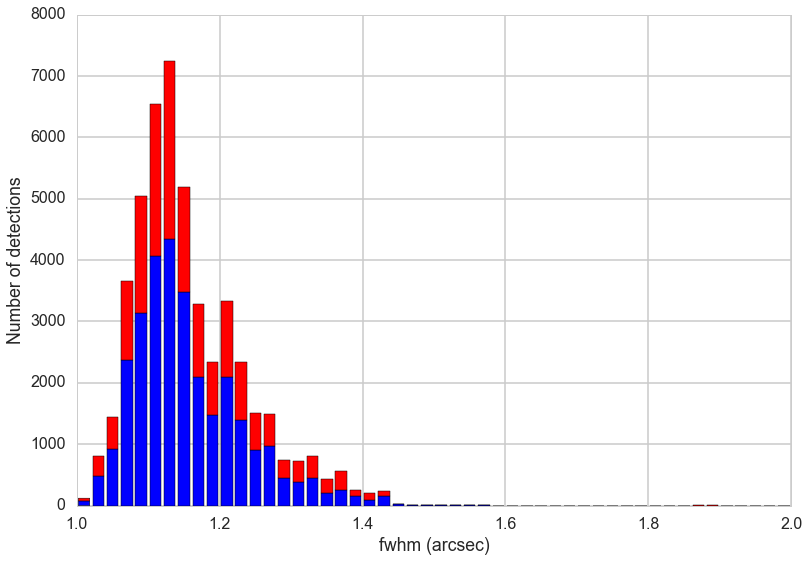

In [57]:
s0 = newdf[good_mask].fwhm.values
s1 = newdf[~good_mask].fwhm.values
colors = ['blue', 'red']
labels = ['good', 'not good']
n, nbins, patches = plt.hist([s0, s1], bins=50, color=colors, label=labels, stacked=True, range=[1,2])

#n, nbins, patches = plt.hist(newdf[good_mask].Y_PSF, bins=200)
plt.xlabel("fwhm (arcsec)")
plt.ylabel("Number of detections")

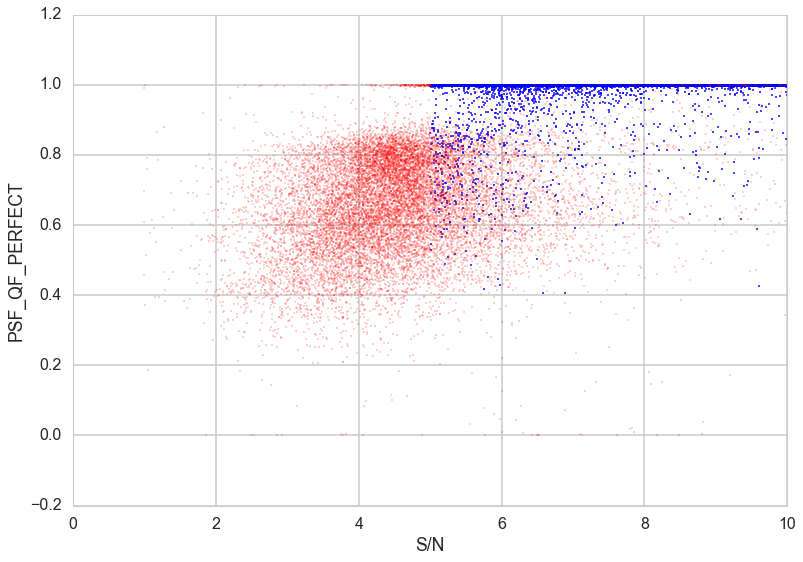

In [58]:
x0 = newdf[good_mask].snr.values
s0 = newdf[good_mask].PSF_QF_PERFECT.values
x1 = newdf[~good_mask].snr.values
s1 = newdf[~good_mask].PSF_QF_PERFECT.values
x2 = newdf[inBox_mask].snr.values
s2 = newdf[inBox_mask].PSF_QF_PERFECT.values
x3 = newdf[flag_mask].snr.values
s3 = newdf[flag_mask].PSF_QF_PERFECT.values
x4 = newdf[magOK_mask].snr.values
s4 = newdf[magOK_mask].PSF_QF_PERFECT.values

#plt.scatter(x3, s3, color='green', label='flags good', s=0.5, alpha=0.5)
#plt.scatter(x2, s2, color='green', label='inBox', s=2.0, alpha=1.0)
plt.scatter(x0, s0, color='blue', label='good', s=2.0, alpha=1.0)
plt.scatter(x1, s1, color='red', label='not good', s=0.5, alpha=0.5)
#plt.scatter(x4, s4, color='green', label='flags good', s=0.5, alpha=0.5)
plt.xlim(0,10)
plt.xlabel("S/N")
plt.ylabel("PSF_QF_PERFECT")

In [59]:
# create new response 'on_match'
# True if on_star == 1 or mp_desig != 'None'
def onmatch(row):
    if row['on_star'] == 1:
        return True
    elif row['mp_desig'] != 'None':
        return True
    else:
        return False

newdf['on_match'] = newdf.apply(onmatch, axis=1)
newdf[:5]

,AP_MAG,AP_MAG_RADIUS,AP_MAG_RAW,CAL_PSF_MAG,CAL_PSF_MAG_SIG,CR_NSIGMA,DEC_PSF,EXT_NSIGMA,FLAGS,FLAGS2,IPP_IDET,KRON_FLUX,KRON_FLUX_ERR,KRON_FLUX_INNER,KRON_FLUX_OUTER,MOMENTS_M3C,MOMENTS_M3S,MOMENTS_M4C,MOMENTS_M4S,MOMENTS_R1,MOMENTS_RH,MOMENTS_XX,MOMENTS_XY,MOMENTS_YY,N_FRAMES,PADDING,PADDING2,PEAK_FLUX_AS_MAG,PLTSCALE,POSANGLE,PSF_CHISQ,PSF_INST_FLUX,PSF_INST_FLUX_SIG,PSF_INST_MAG,PSF_INST_MAG_SIG,PSF_MAJOR,PSF_MINOR,PSF_NDOF,PSF_NPIX,PSF_QF,PSF_QF_PERFECT,PSF_THETA,RA_PSF,SKY,SKY_SIGMA,X_PSF,X_PSF_SIG,Y_PSF,Y_PSF_SIG,mp_dec_rate,mp_desig,mp_mag,mp_prox,mp_ra_rate,on_star,chip,filterID,mag,snr,fwhm,psf_extent,flagsOK,in_box,magOK,qfpOK,BIG_RADIUS,MOMENTS_FAILURE,EXT_LIMIT,EXTERNALPOS,DEFAULT,NONLINEAR_FIT,DEFECT,SKY_FAILURE,LINEAR_FIT,RADIAL_FLUX,PSFSTAR,POORFIT,SKYVAR_FAILURE,PAIR,OFF_CHIP,BLEND,FITFAIL,MOMENTS_SN,SATURATED,BLEND_FIT,AP_MAGS,SIZE_SKIPPED,CR_LIMIT,ON_SPIKE,BADPSF,EXTENDED_FIT,UNDEFINED,EXTENDED_STATS,SATSTAR,FITTED,EXTMODEL,ON_GHOST,PSFMODEL,HAS_BRIGHTER_NEIGHBOR,ON_STARCORE,ON_CONVPOOR,PASS1_SRC,DIFF_SELF_MATCH,BRIGHT_NEIGHBOR_1,SATSTAR_PROFILE,ON_BURNTOOL,BRIGHT_NEIGHBOR_10,DIFF_WITH_DOUBLE,DIFF_WITH_SINGLE,MATCHED,on_match
0,-16.105915,8,-15.989053,11.544366,0.015625,NaN,5.188569,23.870026,640696327,128,0,2771294.25000,2088.662354,794063.500000,183158.296875,0.193679,-1.979877,0.660624,0.040192,5.168977,1.999534,5.839915,-0.347463,11.006875,0,0,0,-11.385881,0.255615,-44.986790,821271.8125,1693271.125000,1653.803101,-15.571816,0.000977,2.270140,1.697595,2703,2704,0.998480,0.998480,0.573213,4.755702,276.657104,17.481617,1575.474365,0.002078,2030.260132,0.002078,NaN,None,NaN,NaN,NaN,1,XY37,y,11.544366,1112.147383,1.181637,4.084059,True,True,True,True,True,False,True,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,True,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True
1,-14.943736,8,-14.826873,12.057705,0.015625,NaN,5.153399,4.367692,103825415,128,1,987895.87500,1202.969482,211830.859375,76612.031250,0.269641,-0.458750,0.035072,-0.042921,3.854464,1.843775,5.546052,-0.261767,5.475727,0,0,0,-11.348567,0.255725,-44.969368,69091.5625,1055336.250000,1273.284912,-15.058477,0.001207,2.101094,1.628697,2690,2691,0.958371,0.958371,45.229836,4.835621,277.131989,17.105103,2631.537598,0.002567,2647.817383,0.002567,NaN,None,NaN,NaN,NaN,1,XY37,y,12.057705,900.390413,1.113961,2.978996,True,True,True,True,True,False,True,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,True,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True
2,-15.665754,8,-15.548891,12.146197,0.015625,NaN,5.247891,38.314117,103825415,160,2,2104803.50000,1825.540527,879232.437500,309640.843750,-0.308689,-6.184803,-0.249143,0.015020,5.365948,1.728602,8.452147,-0.033962,12.142209,0,0,0,-11.265514,0.255899,-44.971111,1324781.8750,972734.437500,1277.515503,-14.969985,0.001313,2.036710,1.648822,2687,2688,0.993818,0.172318,44.426552,4.895709,277.821533,17.326918,2051.020020,0.002794,4115.729980,0.002794,NaN,None,NaN,NaN,NaN,1,XY37,y,12.146197,827.208689,1.104269,5.528164,True,True,True,False,True,False,True,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,True,False,True,False,False,False,True,False,False,False,True,False,False,False,False,True
3,-14.947728,8,-14.830865,14.733263,0.015625,NaN,5.248050,92.086113,36716545,32,3,409750.28125,1009.182800,602965.250000,259217.578125,-0.365963,-5.953179,-0.996090,-0.090508,2.423606,0.776113,4.258163,0.007898,14.550693,0,0,0,-11.234550,0.255900,-44.971077,1095452.8750,89777.585938,808.500732,-12.382919,0.009006,2.036703,1.648822,2687,2688,0.924442,0.165580,45.077869,4.895940,277.823822,17.330652,2051.114746,0.019161,4119.679199,0

In [81]:
# Separate potential classifiers into groups
lcols=list(newdf.columns)

# list of potential continuous features
ccols = ['EXT_NSIGMA','PEAK_FLUX_AS_MAG','POSANGLE',
         'PSF_CHISQ','PSF_MAJOR','PSF_MINOR','PSF_NDOF','PSF_NPIX','PSF_QF_PERFECT','PSF_THETA',
         'SKY','SKY_SIGMA','X_PSF','X_PSF_SIG','Y_PSF','Y_PSF_SIG','mag','snr','fwhm','psf_extent'
        ]

# list of potential indicator features
INDICATORS = ['in_box','BIG_RADIUS','MOMENTS_FAILURE','EXT_LIMIT','EXTERNALPOS','DEFAULT','NONLINEAR_FIT',
              'DEFECT','SKY_FAILURE','LINEAR_FIT','RADIAL_FLUX','PSFSTAR','POORFIT','SKYVAR_FAILURE','PAIR',
              'OFF_CHIP','BLEND','FITFAIL','MOMENTS_SN','SATURATED','BLEND_FIT','AP_MAGS','SIZE_SKIPPED',
              'CR_LIMIT','ON_SPIKE','BADPSF','EXTENDED_FIT','UNDEFINED','EXTENDED_STATS','SATSTAR','FITTED',
              'EXTMODEL','ON_GHOST','PSFMODEL','HAS_BRIGHTER_NEIGHBOR','ON_STARCORE','ON_CONVPOOR','PASS1_SRC',
              'DIFF_SELF_MATCH','BRIGHT_NEIGHBOR_1','SATSTAR_PROFILE','ON_BURNTOOL','BRIGHT_NEIGHBOR_10',
              'DIFF_WITH_DOUBLE','DIFF_WITH_SINGLE'
             ]

# anything which isn't in INDICATORS or ccols will be added to 'other'
other = []

# list of all features under consideration
testfeatures = []
for i in INDICATORS:
    testfeatures.append(i)
for c in ccols:
    testfeatures.append(c)   
for c in lcols:
    if c not in testfeatures:
        other.append(c)

print 'potential continuous predictors:',len(ccols)
print 'potential indicators:',len(INDICATORS)
print 'other columns:',len(other)
print 'newdf shape:',newdf.shape

potential continuous predictors: 20
potential indicators: 45
other columns: 46
newdf shape: (48856, 111)


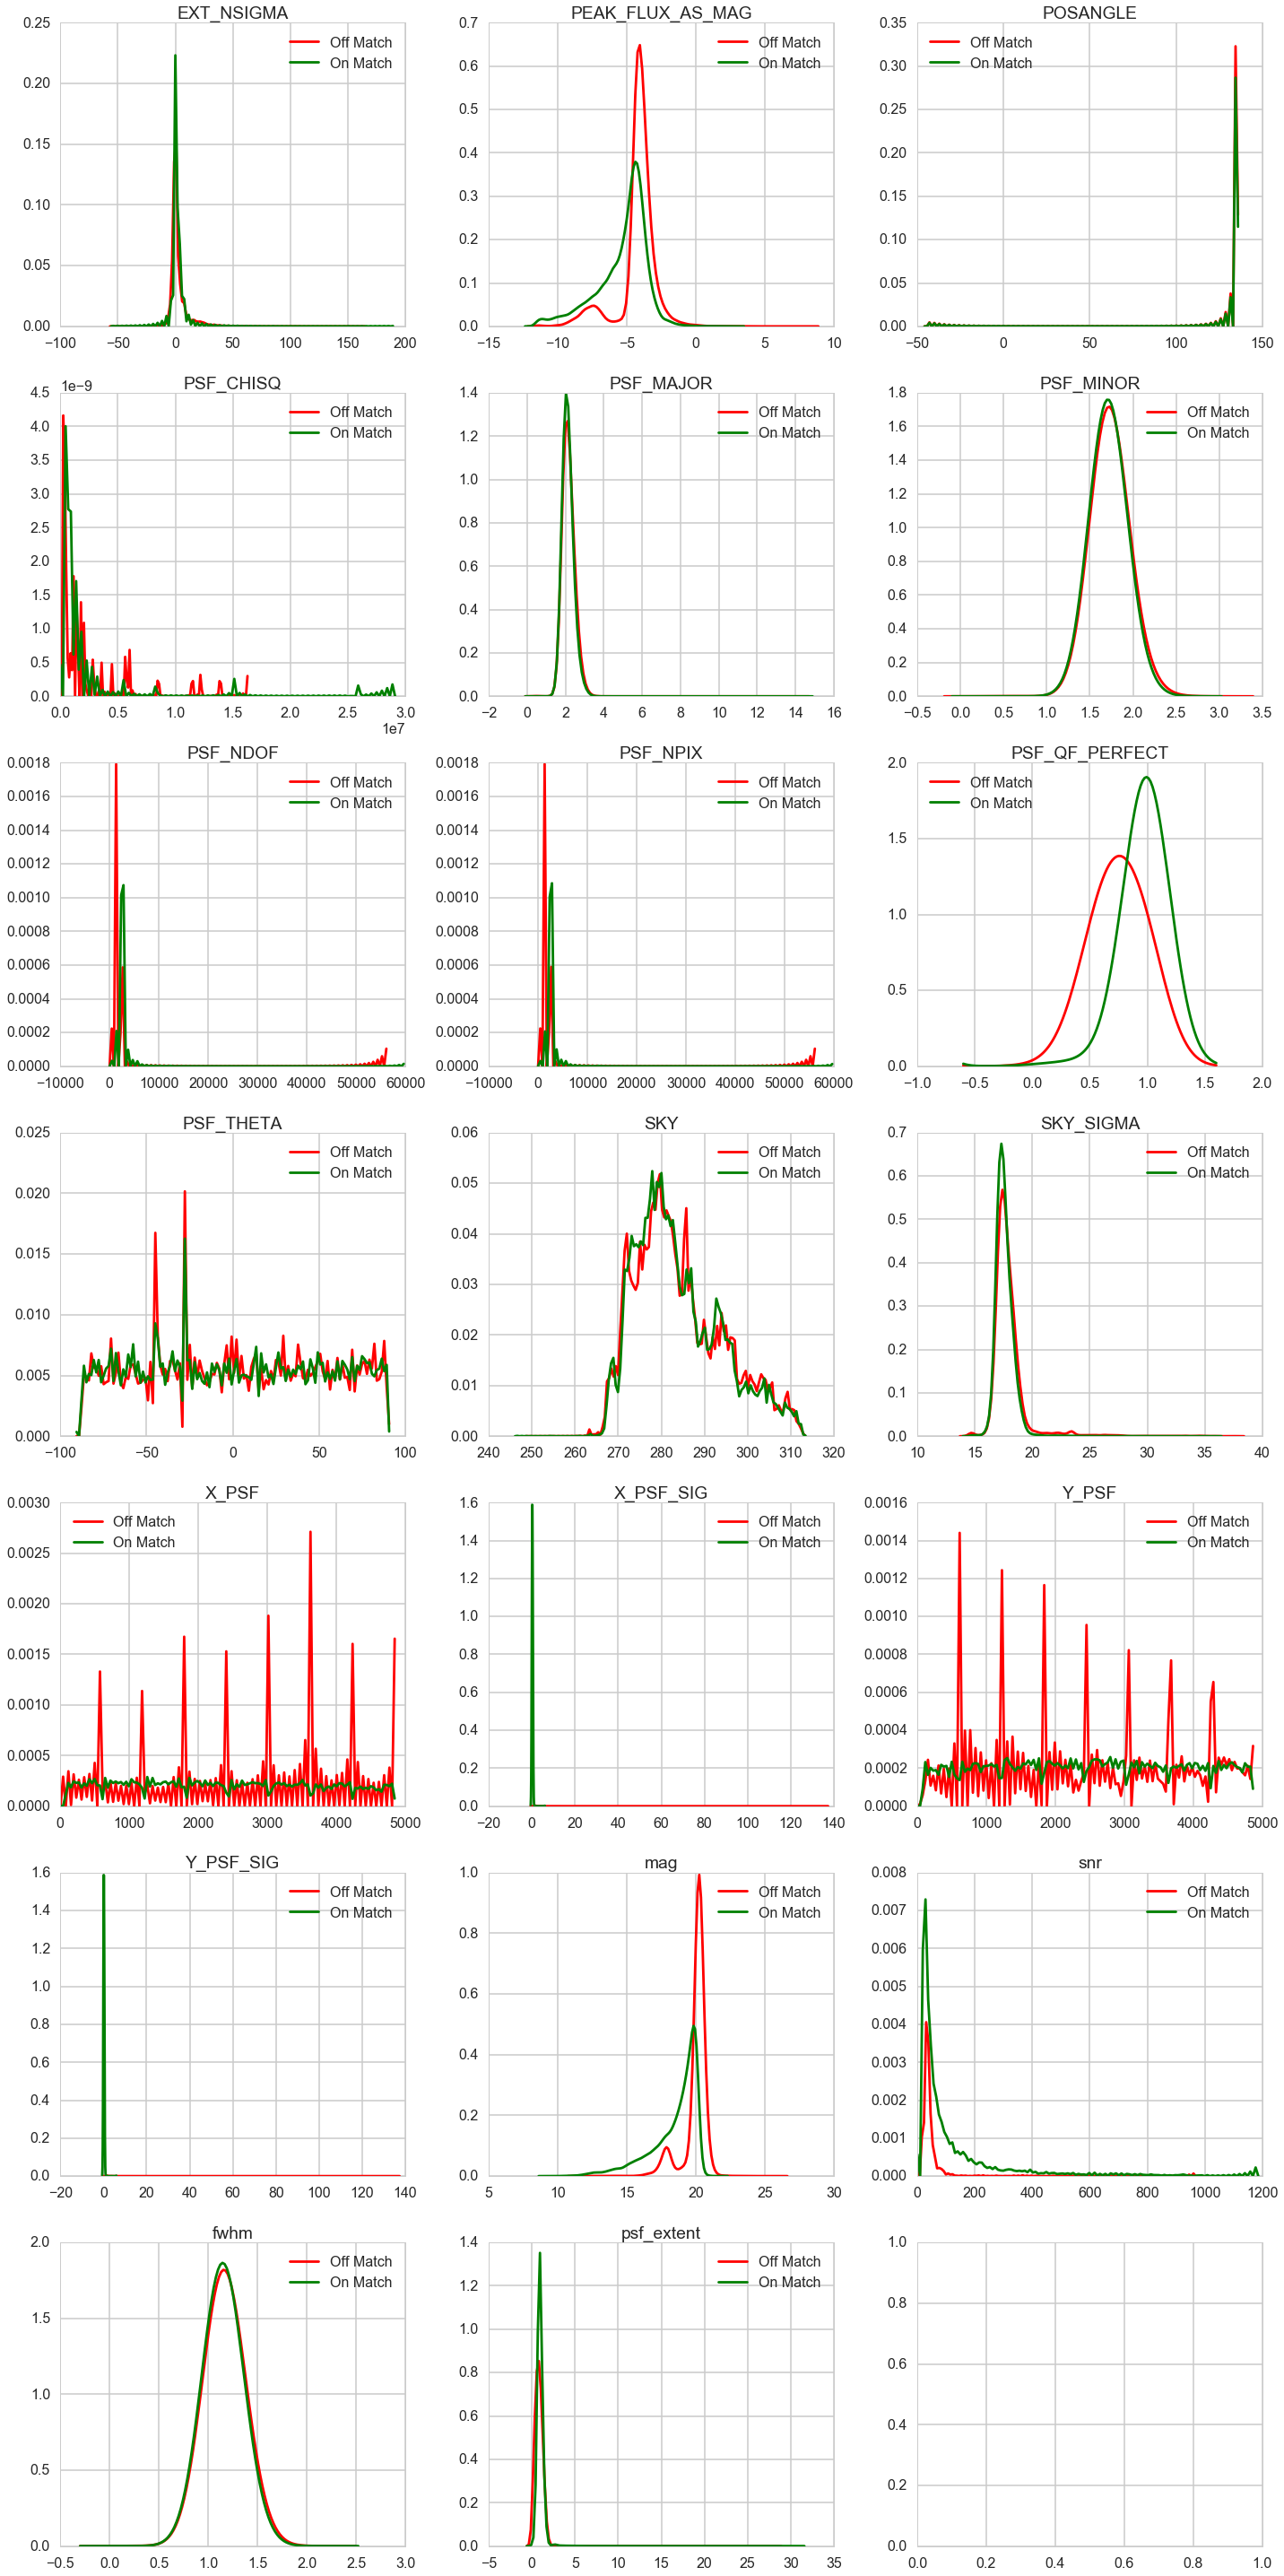

In [84]:
# create kernel density plots for continuous features EDA
fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(20, 40), tight_layout=True)
colors=["r","g"]
labels=["Off Match", "On Match"]
for ax, col in zip(axes.ravel(), ccols): 
    for r in [0, 1]:
        color = colors[r]
        label = labels[r]
        mask_r = newdf.on_match == r
        # plot kernel densities - I've picked bandwidth to smooth out the plots a bit, but is this ideal?
        # more on bandwidths https://jakevdp.github.io/blog/2013/12/01/kernel-density-estimation/
        sns.kdeplot(newdf[mask_r][col], bw=.2, ax=ax, color=color, label=label)
        ax.set_title(col)

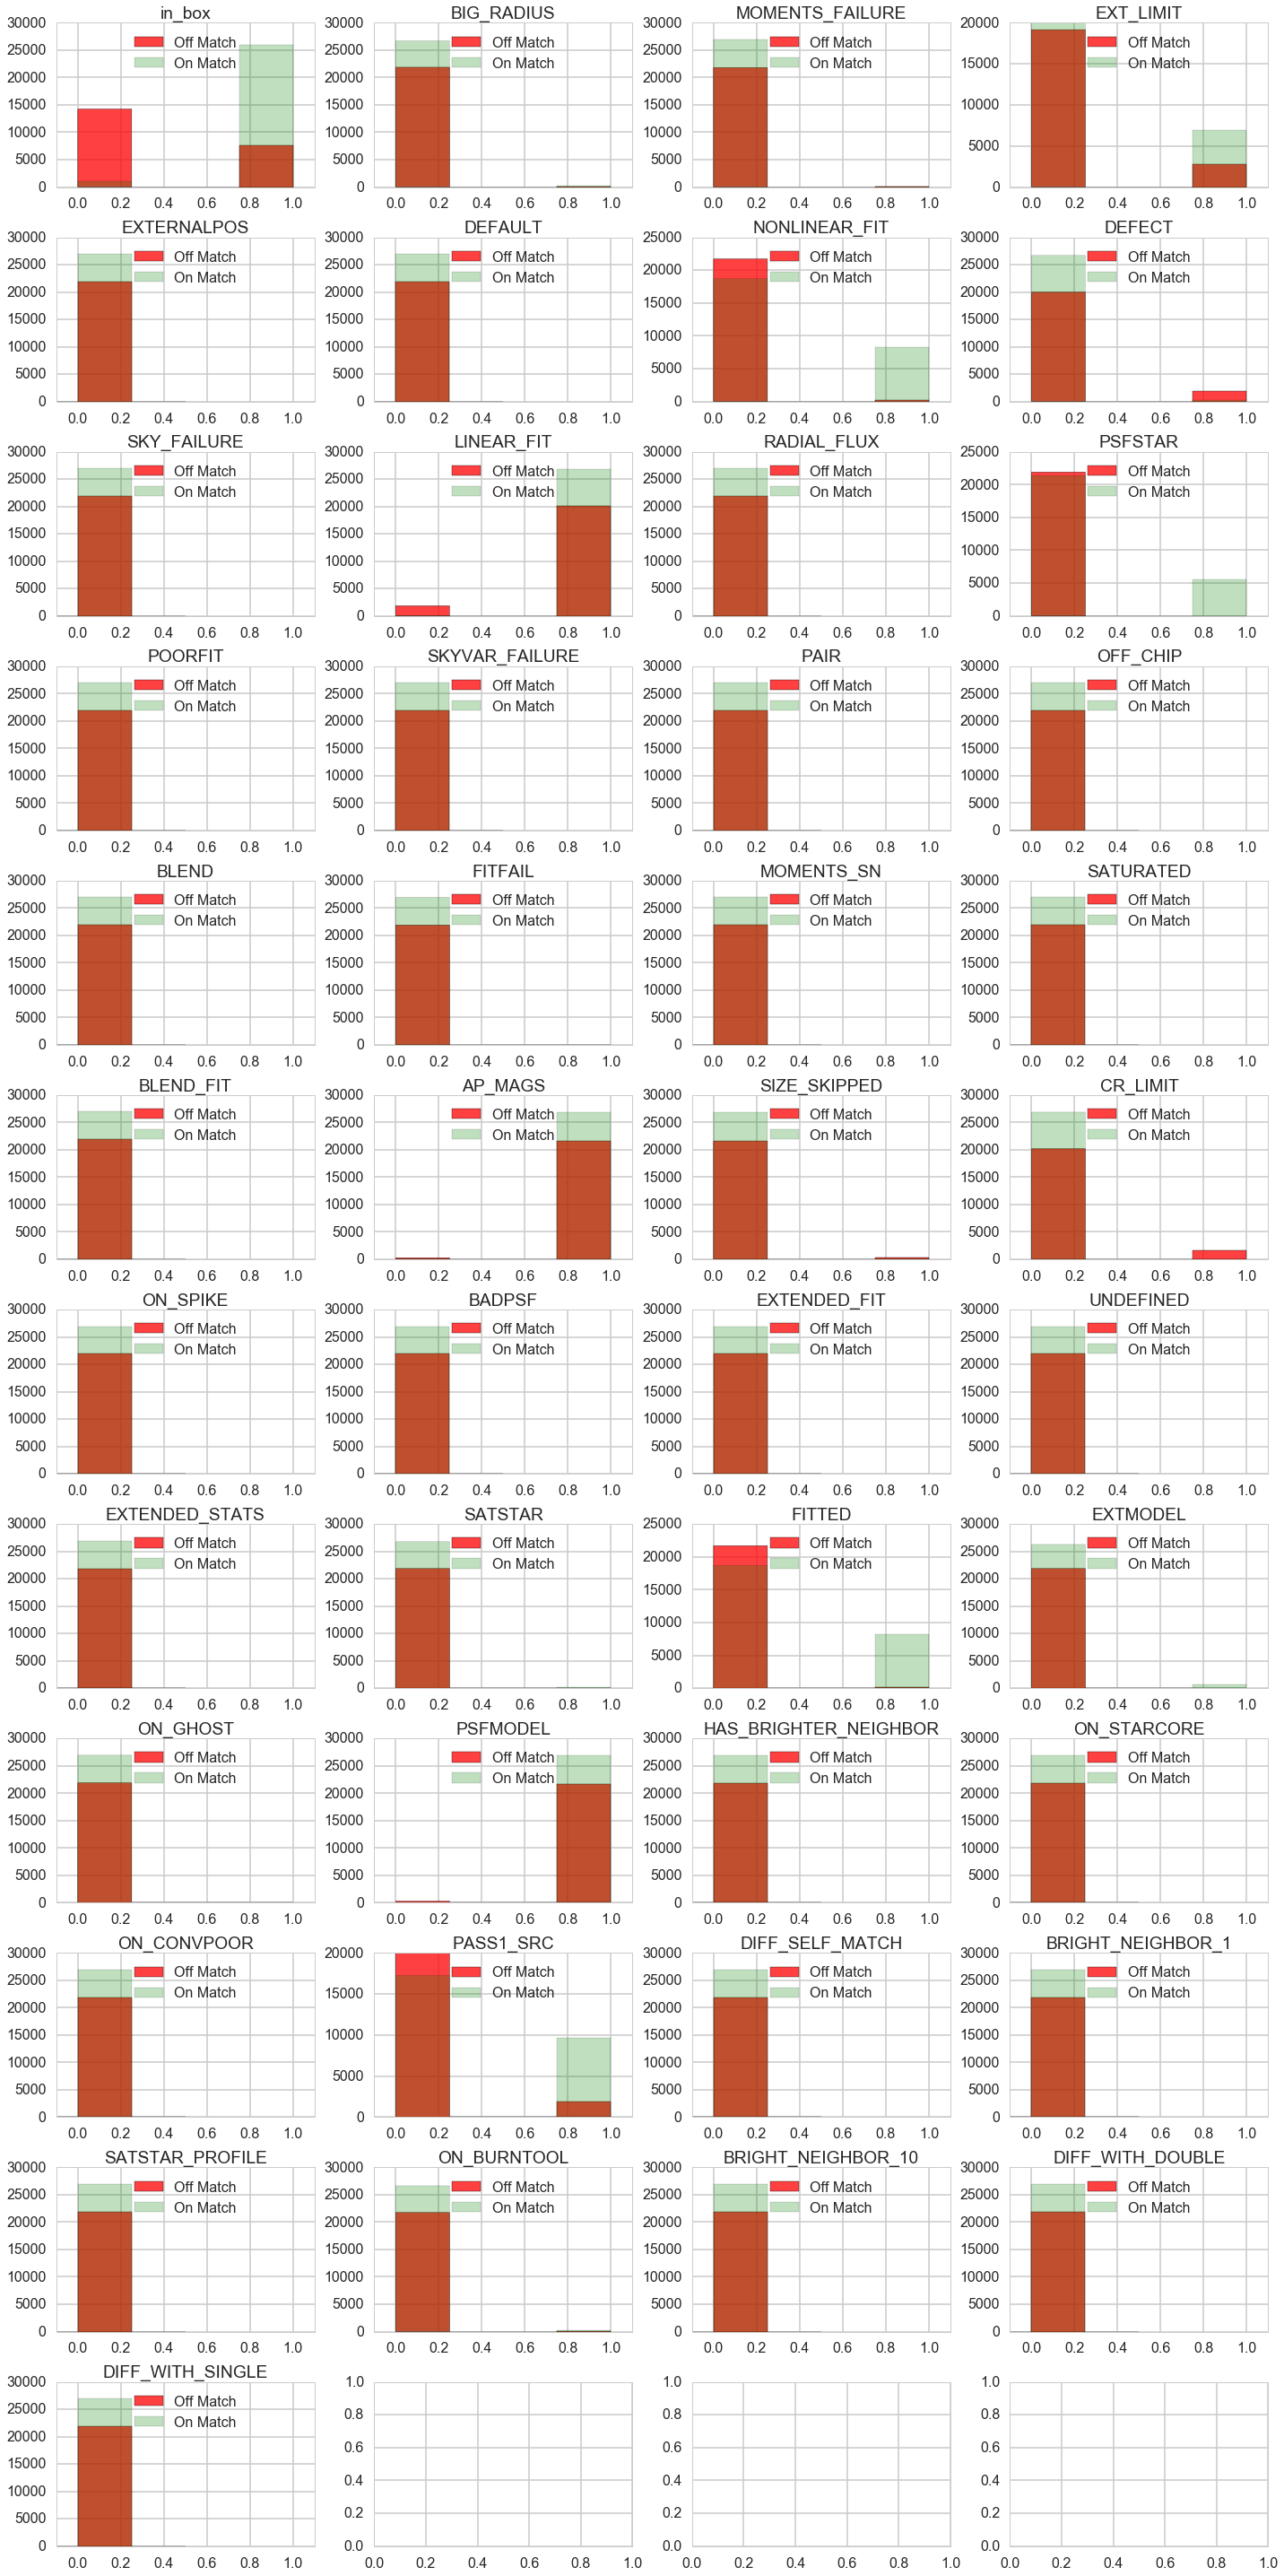

In [93]:
# create kernel density plots for indicator features EDA
fig, axes = plt.subplots(nrows=12, ncols=4, figsize=(20, 40), tight_layout=True)
colors=["r","g"]
labels=["Off Match", "On Match"]
alphas=[.75, .25]
for ax, ind in zip(axes.ravel(), INDICATORS):
    for r in [0, 1]:
        color = colors[r]
        label = labels[r]
        alpha = alphas[r]
        mask_r = newdf.on_match == r
        ax.hist(newdf[mask_r][ind].values, bins=4, color=color, alpha=alpha, label=label, stacked=True)
        ax.set_title(ind)
        ax.set_xlim([-.1,1.1])
        ax.legend(loc='upper center')

In [63]:
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

In [64]:
def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    
    gs.fit(X, y)
    
    print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_
    best = gs.best_estimator_
    return best

In [65]:
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, score_func=None, n_folds=5, n_jobs=1):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    
    if mask !=None:
        print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    
    scaler = StandardScaler()
    Xtrain_scaled = scaler.fit_transform(Xtrain)
    
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain_scaled, ytrain, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    print confusion_matrix(ytest, clf.predict(Xtest))
    print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest

In [102]:
features = ['PSF_QF_PERFECT','snr']

In [103]:
# The block below filters out records where the value is NaN
init = np.ones(newdf.shape[0], dtype='int')

for i,feature in enumerate(features):
    temp_mask = ~np.isnan(newdf[feature])
    
    if i == 0:
        final_mask = init & temp_mask
    else:
        final_mask = final_mask & temp_mask

newdf2 = newdf[final_mask]
print 'newdf shape:',newdf.shape
print 'newdf2 shape:',newdf2.shape

newdf shape: (48856, 111)
newdf2 shape: (48488, 111)


In [101]:
itrain, itest = train_test_split(xrange(newdf2.shape[0]), train_size=0.6)

mask         = np.ones(newdf2.shape[0], dtype='int')
mask[itrain] = 1
mask[itest]  = 0

mask = (mask==1)

In [69]:
from sklearn.linear_model import LogisticRegression
clflog = LogisticRegression()

parameters = {"C": [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}

clflog, Xtrain, ytrain, Xtest, ytest=do_classify(clflog, parameters, newdf2, 
                                                 featurenames = features,
                                                 targetname = 'on_match', 
                                                 target1val = 1, 
                                                 mask = mask)

using mask
BEST {'C': 1} 0.848858792795 [mean: 0.84649, std: 0.02926, params: {'C': 0.001}, mean: 0.84783, std: 0.02838, params: {'C': 0.01}, mean: 0.84858, std: 0.02792, params: {'C': 0.1}, mean: 0.84886, std: 0.02796, params: {'C': 1}, mean: 0.84886, std: 0.02796, params: {'C': 10}, mean: 0.84886, std: 0.02796, params: {'C': 100}, mean: 0.84886, std: 0.02796, params: {'C': 1000}, mean: 0.84886, std: 0.02796, params: {'C': 10000}]
############# based on standard predict ################
Accuracy on training data: 0.85
Accuracy on test data:     0.85
[[ 6154  2486]
 [  477 10279]]
########################################################


C:\Users\apgarc\AppData\Local\Continuum\Anaconda\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [70]:
print 'snr_thresh =',clflog.coef_[0][0]
print 'qpf_thresh =',clflog.coef_[0][1]

snr_thresh = 10.5914805745
qpf_thresh = 0.0227580183764


In [71]:
from sklearn.svm import SVC
clfsvm = SVC(kernel="linear")

parameters = {"C": [0.001, 0.01, 0.1, 1]}

clfsvm, Xtrain, ytrain, Xtest, ytest=do_classify(clfsvm, parameters, newdf2, 
                                                 featurenames = features,
                                                 targetname = 'on_match', 
                                                 target1val = 1, 
                                                 mask = mask)

using mask
BEST {'C': 1} 0.847105733535 [mean: 0.84257, std: 0.02983, params: {'C': 0.001}, mean: 0.84683, std: 0.02847, params: {'C': 0.01}, mean: 0.84704, std: 0.02831, params: {'C': 0.1}, mean: 0.84711, std: 0.02831, params: {'C': 1}]
############# based on standard predict ################
Accuracy on training data: 0.85
Accuracy on test data:     0.84
[[ 6142  2498]
 [  511 10245]]
########################################################


C:\Users\apgarc\AppData\Local\Continuum\Anaconda\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
